In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import math
from scipy import stats
import pandas as pd
import matplotlib as mpl
import datetime as dt
from pandas_datareader import data as pdr
import plotly.offline as plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
yf.pdr_override()
import os
plotly.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'
import wrds
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

### Importing DataFrames & changing index to date time

In [2]:
df_close_clean = pd.read_csv('data/df_close_clean.csv')
df_open_clean = pd.read_csv('data/df_open_clean.csv')
df_volume_clean = pd.read_csv('data/df_volume_clean.csv')
df_shares_outstanding_clean = pd.read_csv('data/df_shares_outstanding_clean.csv')
df_volume_clean_wrds = pd.read_csv('data/df_volume_clean_WRDS.csv')

# change index to datetime
df_close_clean.index = pd.to_datetime(df_close_clean['Date'])
df_open_clean.index = pd.to_datetime(df_open_clean['Date'])
df_volume_clean.index = pd.to_datetime(df_volume_clean['Date'])
df_shares_outstanding_clean.index = pd.to_datetime(df_shares_outstanding_clean['Date'])
df_volume_clean_wrds.index = pd.to_datetime(df_volume_clean_wrds['Date'])

# Remove the "Date" column as it no longer has any use
df_close_clean = df_close_clean.drop(columns=['Date'])
df_open_clean = df_open_clean.drop(columns=['Date'])
df_volume_clean = df_volume_clean.drop(columns=['Date'])
df_shares_outstanding_clean = df_shares_outstanding_clean.drop(columns=['Date'])
df_volume_clean_wrds = df_volume_clean_wrds.drop(columns=['Date'])
# df_close_clean = df_close_clean.drop(columns=['Date.1'])
# df_open_clean = df_open_clean.drop(columns=['Date.1'])
# df_volume_clean = df_volume_clean.drop(columns=['Date.1'])
df_shares_outstanding_clean = df_shares_outstanding_clean.drop(columns=['Date.1'])
df_volume_clean_wrds = df_volume_clean_wrds.drop(columns=['Date.1'])

# testing if the index is datetime and the "Date" column is removed
assert 'Date' not in df_close_clean.columns
assert 'Date' not in df_open_clean.columns
assert 'Date' not in df_volume_clean.columns
assert 'Date' not in df_shares_outstanding_clean.columns
assert 'Date' not in df_volume_clean_wrds.columns
assert df_close_clean.index.dtype == 'datetime64[ns]'
assert df_open_clean.index.dtype == 'datetime64[ns]'
assert df_volume_clean.index.dtype == 'datetime64[ns]'
assert df_shares_outstanding_clean.index.dtype == 'datetime64[ns]'
assert df_volume_clean_wrds.index.dtype == 'datetime64[ns]'

### Velocity calculation

We do the velocity calculation on the real data a fashion similar as Feng et. al's 2012 paper, in the following steps:
1. Divide the total number of shares traded on the market(volume) by the number of outstanding shares of each stock every day
2. Resample the dataframe into a yearly timeframe
3. Sum up the yearly velocity per stock and divide it by the amount of years used in the dataframe which results in the mean velocity per stock
4. Take the mean of all the mean of the different stocks

In [3]:
df_volume_clean_wrds

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,6290038.0,43167060.0,800421.0,19986670.0,13767660.0,1972401.0,20266410.0,977536.0,4039095.0,6483720.0,...,6594952.0,2486815.0,2702053.0,16144970.0,856539.0,927252.0,4376855.0,1397462.0,213748.0,2551059.0
2013-01-03,4114289.0,43167060.0,520539.0,12579170.0,16739210.0,2027242.0,22148090.0,655362.0,3340674.0,3905904.0,...,3967047.0,1731879.0,2403510.0,13268470.0,525445.0,610706.0,2627253.0,1574966.0,99849.0,2267804.0
2013-01-04,4601506.0,43167060.0,614933.0,21196320.0,21372200.0,2462183.0,15819140.0,530563.0,3145680.0,3809146.0,...,3624749.0,2129025.0,1743995.0,11427870.0,660389.0,563325.0,2719375.0,1189537.0,145944.0,3577660.0
2013-01-07,2567557.0,43167060.0,1051969.0,17262620.0,17896920.0,1803504.0,13121470.0,423123.0,2262426.0,3632022.0,...,2450680.0,1500928.0,2853210.0,11799780.0,554059.0,481287.0,3729703.0,954238.0,90581.0,2285917.0
2013-01-08,2787813.0,43167060.0,840003.0,16350190.0,17863000.0,1533163.0,15053860.0,580903.0,2468876.0,3080868.0,...,5203250.0,975921.0,3762904.0,14228400.0,698803.0,1084482.0,12406140.0,905965.0,112590.0,3758558.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,779426.0,17160810.0,524534.0,63755280.0,2684724.0,528005.0,2618369.0,890265.0,1213251.0,1627915.0,...,1932785.0,1134475.0,1201346.0,11534290.0,1264320.0,321094.0,699735.0,789770.0,180932.0,1263345.0
2022-12-27,879543.0,18836880.0,717073.0,68887690.0,2669090.0,740310.0,2927352.0,666705.0,1009563.0,1463215.0,...,2265992.0,4024281.0,1580610.0,11874640.0,998778.0,468173.0,1299183.0,742499.0,252510.0,704184.0
2022-12-28,784312.0,20388570.0,685513.0,85247210.0,2944327.0,804725.0,3264409.0,1107929.0,1386969.0,1668511.0,...,2244112.0,2131050.0,1513689.0,10675270.0,1430535.0,480378.0,964755.0,750108.0,241209.0,679957.0


In [4]:
# Step 1
velocity_df_daily = df_volume_clean_wrds/df_shares_outstanding_clean

# Step 2
velocity_yearly_df = velocity_df_daily.resample('Y').sum()

# Step 3 + 4
sum_velocity_yearly_df = velocity_yearly_df.apply(lambda x: x.sum())/velocity_yearly_df.shape[0] # .shape[0] = amount of rows 
V = sum_velocity_yearly_df.mean()

In [5]:
def probability_of_trading(V_f:float, V:float) -> float:
    """returns the probability of trading for a given velocity of fundamental traders and total market velocity V"""
    # V is total market velocity, V_f is the velocity of fundamental traders, V_c is the velocity of technical traders
    # We assume that the proportion of shares held by fundamental traders is the same as in the period 1997-2006, namely 83% on average. 
    # This might be a bit strong, but we continue with this assumption for now.
    # thus the velocity of technical traders is V_C is given by:
    V_c = (V - 0.83*V_f)/(1-0.83)
    # because there are around 250 trading days in a year, we arrive at probability of trading p as follows:
    p = V_c/(250*2)
    return p


In [6]:
# multiple choices of V_F, in the paper they chose V_f = 0.4 as an arbirtrary choice which achieved best fit
V_f_list = [0.2, 0.4, 0.6, 0.8]

print("The V value is", V)
for V_f in V_f_list:
    p = probability_of_trading(V_f, V)
    print('V_f: ' + str(V_f), 'gives a p value of', p)


The V value is 2.183549851113631
V_f: 0.2 gives a p value of 0.02373588060133683
V_f: 0.4 gives a p value of 0.02178293942486624
V_f: 0.6 gives a p value of 0.019829998248395653
V_f: 0.8 gives a p value of 0.01787705707192506


# Model parameters

In [7]:
# other parameters
n = 2**10
t = 10000
p = 0.02178
omega = 1
b = 1
size = 1
k = 1
M = 500
d = 1.12

# Model definition: ABM

In [8]:
# agent behaviors for buying, selling and holding based on the probability of trading p
def buy_sell_hold(p, amount_times):
    assert p <= 0.5, "p should be smaller than 0.5"
    psis = np.zeros(amount_times)
    dice_rolls = np.random.uniform(0, 1, amount_times)
    indices = np.nonzero(dice_rolls <= 2*p)

    for index in indices[0]:
        if np.random.randint(0,2) == 0:
            psis[index] = 1
        else:
            psis[index] = -1
    return psis


In [9]:
assert len(buy_sell_hold(0.2,10)) == 10

In [10]:
# Agent model w noise

class Model:
    def __init__(self, p: float, n: int, size: int, k: int, omega: int, b: int) -> None:
        self.n = n
        self.p = p
        self.daily_return = 1
        self.trading_volume = 0
        self.k = k
        self.omega = omega
        self.daily_returns = []
        self.count = 0
        self.b = b

        self.daily_trading_volumes = []

        
    def distribute_opinion_groups(self) -> int:
        if self.b == 0:
            # number of opinion groups
            c = (self.n / abs(self.daily_return)) ** self.omega
                
        else:
            mean = (self.n / abs(self.daily_return)) ** self.omega

            
            c = np.random.normal(loc = mean, scale = math.sqrt(mean * self.b))
            c = int(np.round(c))
            # because logically there can only be a minimum of 1 opinion group, i.e. all agents have the same opinion, we set the minimum c to be 1.
            if c <= 0:
                c = 1
            if abs(self.daily_return) >= self.n:
                c = 1
        # rounding, as we can only have whole number of opinion groups
        c = int(np.round(c))

        # number of opnion groups can maximally be the number of agents
        c = np.min([c, self.n])
            
        return c

    def step(self):
        self.count += 1
        c = self.distribute_opinion_groups()
        psis = buy_sell_hold(self.p, c)
        average_agents_per_group = int(np.round(self.n/c))
        return_matrix = psis * average_agents_per_group
        trading_volume = np.sum(np.abs(return_matrix))
        self.daily_return = np.sum(return_matrix) #* k
         # following the boundry conditions on returns from Feng et al. 2012 appendix 5:
        minimum_return = self.n**((self.omega-1)/self.omega)
        if np.abs(self.daily_return) < minimum_return:
            sign = -1 if self.daily_return < 0 else 1
            self.daily_return = sign*minimum_return
        maximum_return = self.n
        if np.abs(self.daily_return) > maximum_return:
            self.daily_return = np.sign(self.daily_return)*maximum_return
        self.daily_returns.append(self.daily_return)
        self.daily_trading_volumes.append(trading_volume)
        return self.count

# ABM test run

In [11]:
# ABM simulation
model_test = Model(p, n, size, k, omega, b)
for i in range(t):
    model_test.step()


In [12]:
model_test.daily_returns

[-3.0,
 -12.0,
 1.0,
 1.0,
 -9.0,
 9.0,
 16.0,
 -17.0,
 1.0,
 4.0,
 -8.0,
 1.0,
 10.0,
 1.0,
 -3.0,
 6.0,
 -12.0,
 1.0,
 -3.0,
 -3.0,
 -6.0,
 -6.0,
 6.0,
 6.0,
 15.0,
 1.0,
 1.0,
 6.0,
 -6.0,
 12.0,
 36.0,
 1.0,
 8.0,
 8.0,
 16.0,
 -17.0,
 -38.0,
 102.0,
 170.0,
 1.0,
 -3.0,
 -6.0,
 6.0,
 6.0,
 6.0,
 -14.0,
 1.0,
 1.0,
 -11.0,
 26.0,
 -33.0,
 1.0,
 13.0,
 44.0,
 51.0,
 1.0,
 1.0,
 5.0,
 -12.0,
 -24.0,
 1.0,
 -5.0,
 5.0,
 20.0,
 -48.0,
 1.0,
 6.0,
 -14.0,
 -34.0,
 33.0,
 1.0,
 -11.0,
 -20.0,
 -16.0,
 1.0,
 4.0,
 -16.0,
 16.0,
 15.0,
 26.0,
 69.0,
 -90.0,
 1.0,
 -8.0,
 9.0,
 -24.0,
 21.0,
 44.0,
 1.0,
 -1.0,
 1.0,
 8.0,
 1.0,
 8.0,
 24.0,
 19.0,
 20.0,
 -46.0,
 -64.0,
 1.0,
 6.0,
 1.0,
 -11.0,
 -24.0,
 24.0,
 -28.0,
 33.0,
 -30.0,
 -70.0,
 60.0,
 1.0,
 13.0,
 26.0,
 29.0,
 -29.0,
 1.0,
 4.0,
 4.0,
 12.0,
 1.0,
 -1.0,
 8.0,
 1.0,
 5.0,
 -40.0,
 -30.0,
 -54.0,
 45.0,
 -43.0,
 1.0,
 1.0,
 3.0,
 1.0,
 6.0,
 6.0,
 -6.0,
 -18.0,
 -17.0,
 -15.0,
 -39.0,
 1.0,
 -3.0,
 -18.0,
 17.0,
 45.0,
 1.0,


In [13]:
# Nitai's variabe transformations:
# converting data to array, taking asolute value, and normalizing with standard scaler to zero mean and unit variance, using sklearn StandardScaler. reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
array_AMB_returns = np.array(model_test.daily_returns)
abs_AMB_returns = np.abs(array_AMB_returns)
# checking if abs transformation worked
assert abs_AMB_returns.min() == 1
scaler = StandardScaler()
scaled_abs_ABM_returns = scaler.fit_transform(abs_AMB_returns.reshape(-1, 1))
# checking if standard scaling worked
assert abs_AMB_returns.max() > scaled_abs_ABM_returns.max()

In [14]:
log_scaled_abs_AMB_returns = np.log(scaled_abs_ABM_returns)

C:\Users\iChin\AppData\Local\Temp/ipykernel_30300/1685117646.py:1: RuntimeWarning:

invalid value encountered in log



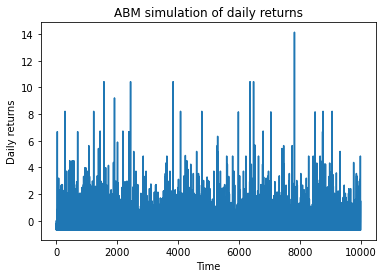

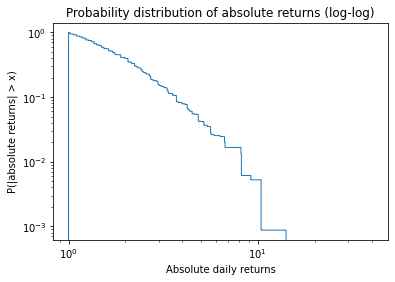

In [15]:
# logarithmic bins
bin=np.logspace(start=0, stop=np.log(5), num=t)



plt.plot(scaled_abs_ABM_returns)
plt.title("ABM simulation of daily returns")
plt.xlabel("Time")
plt.ylabel("Daily returns")
plt.show()

plt.figure(1)
plt.hist(scaled_abs_ABM_returns, bin, cumulative=-1, density=True, log=True, histtype='step')
plt.title("Probability distribution of absolute returns (log-log)")
plt.xlabel("Absolute daily returns")
plt.ylabel("P(|absolute returns| > x)")
plt.gca().set_xscale("log")
plt.show()


# Model definition: Stochastic model

In [16]:
class Stochastic_Model:
    def __init__(self, n: int, p: float, init: int, time_horizon: bool, M, d):
        self.returns = [init]
        self.n = n
        self.p = p
        self.time_horizon = time_horizon
        self.M = M
        self.d = d

    def time_horizons(self):
        time_horizons = []
        alpha = []

        # distribution of agents in different time horizons
        # agents are allocated to each time horizon (with exponential decay as we go back in time), until we reach the limit M
        # or until we reach the beginning of the simulation (if current timestep t < M)
        for i in range(1, self.M + 1):
            if len(self.returns) == 1:
                value = (i ** -self.d) * abs(self.returns[-1])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            elif i >= len(self.returns):
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[0])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            else:
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[-1-i])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

        return sum(time_horizons) * (sum(alpha) ** -1)

    def step(self):

        # Agents only factor in the returns at the previous timestep
        if self.time_horizon == False:
            variance  = 2 * p * n * abs(self.returns[-1])
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)
        
        # Agents look back M timesteps
        if self.time_horizon == True:
            horizons = self.time_horizons()
            variance  = 2 * p * n * horizons
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)  

# Stochastic model test run

In [17]:
# Stochastic simulation

stochastic = Stochastic_Model(n, p, 10, time_horizon=False, M=10, d=1.12)
stochastic_horizons = Stochastic_Model(n, p, 10, time_horizon=True, M=10, d=1.12)

for i in range(t):
    stochastic.step()
    stochastic_horizons.step()

In [18]:
# Nitai's variabe transformations:
# changing datatype to array
stochastic_returns_array = np.array(stochastic.returns)
stochastic_returns_horizons_array = np.array(stochastic_horizons.returns)
# taking absolute value
stochastic_returns_abs = np.abs(stochastic_returns_array)
stochastic_returns_horizons_abs = np.abs(stochastic_returns_horizons_array)
# normalizing with standard scaler
scaler = StandardScaler()
scaled_stochastic_returns = scaler.fit_transform(stochastic_returns_abs.reshape(-1, 1))
scaled_stochastic_returns_horizons = scaler.fit_transform(stochastic_returns_horizons_abs.reshape(-1, 1))


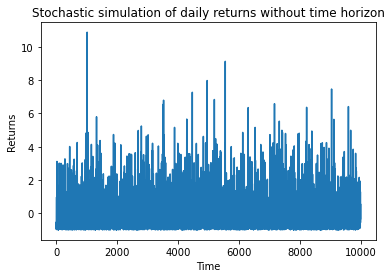

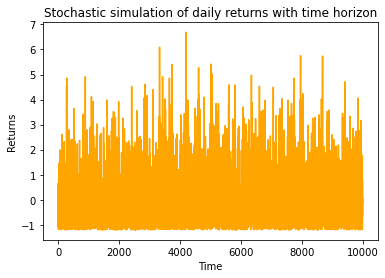

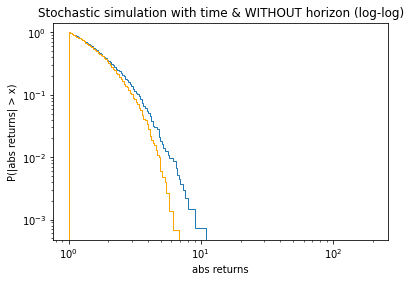

In [19]:
#stochastic simulation return plots

plt.title("Stochastic simulation of daily returns without time horizon")
plt.plot(range(t + 1), scaled_stochastic_returns)
plt.xlabel("Time")
plt.ylabel("Returns")
plt.show()

plt.title("Stochastic simulation of daily returns with time horizon")
plt.plot(range(t+1), scaled_stochastic_returns_horizons, color='orange')
plt.xlabel("Time")
plt.ylabel("Returns")
plt.show()

# Nitai's code: returns normalized previously
abs_returns = scaled_stochastic_returns
abs_returns_horizons = scaled_stochastic_returns_horizons


bin=np.logspace(start=0, stop=np.log(10), num=200)

plt.hist(abs_returns, bins=bin, cumulative=-1, density=True, log=True, histtype='step', label='without time horizon')
plt.hist(abs_returns_horizons, bin, cumulative=-1, density=True, log=True, histtype='step', color = 'orange', label='with time horizon')
bins_heights = plt.hist(abs_returns_horizons, bin, cumulative=-1, density=True, log=True, histtype='step', color = 'orange')[0]
plt.gca().set_xscale("log")
plt.title('Stochastic simulation with time & WITHOUT horizon (log-log)')	
plt.xlabel('abs returns')
plt.ylabel('P(|abs returns| > x)')
plt.show()

# Simulation functions

In [20]:
# (self, n: int, p: float, init: int, time_horizon: bool, M, d)

In [21]:
def run_ABM(p, n, size, k, omega, b, t, runs):
    ''' Runs the ABM model for a given number of runs and time steps. Returns a list of lists of daily returns and a list of lists of trading volume.'''
    ABM_sim_results_returns = []
    ABM_sim_results_volume = []
    for run in range(runs):
        model = Model(p, n, size, k, omega, b)
        for i in range(t):
            model.step()
        print(f"Run {run} completed")
        ABM_sim_results_returns.append(model.daily_returns)
        ABM_sim_results_volume.append(model.daily_trading_volumes)    
    ABM_sim_results_returns_array = np.array(ABM_sim_results_returns)
    ABM_sim_results_volume_array = np.array(ABM_sim_results_volume)
    return ABM_sim_results_returns_array, ABM_sim_results_volume_array
        

In [22]:
def run_Stochastic_Model(n: int, p: float, init: int, time_horizon: bool, M, d, t, runs):
    ''' Runs the stochastic model for a given number of runs and time steps, outputs a list of lists of daily returns and a list of lists of trading volume.'''
    Stochastic_Model_sim_results_returns = []
    Stochastic_Model_sim_results_volume = []
    for run in range(runs):
        model = Stochastic_Model(n=n, p=p, init=10, time_horizon=time_horizon, M=M, d=d)
        for i in range(t):
            model.step()
        print(f"Run {run} completed")
        Stochastic_Model_sim_results_returns.append(model.returns)
    Stochastic_Model_sim_results_return_array = np.array(Stochastic_Model_sim_results_returns)
    return Stochastic_Model_sim_results_return_array

# Hill estimator function

In [23]:
# The following Hill estimator coded according description in https://cran.r-project.org/web/packages/ptsuite/vignettes/ptsuite_vignette.pdf
def Hill_estimator(data, tail_percentage):
    """
    Returns the Hill Estimators for some 1D data set.
    """  
    # sort data in such way that the smallest value is first and the largest value comes last:
    Y = np.sort(data)
    n = len(Y)
    k = int(np.round((tail_percentage * n)/100))
    log_x_n_minus_k = np.log(Y[n-k-1])
    log_x_n_minus_j_plus_1 = np.log(Y[-k:])

    alpha_est = k *(np.sum(log_x_n_minus_j_plus_1 - log_x_n_minus_k))**(-1)

    return alpha_est

In [24]:
def normalise(returns):
    """
    Normalises an array
    """
    array = np.ravel(returns)
    return np.abs((array - array.mean())/array.std())

In [25]:
# regress the Hill estimator of abs returns on log V_f
def plot_regression(range, data, title, x_label, y_label, variance: bool):
    X = np.array(range).reshape(-1,1)
    if variance:
        y = data
    else:
        y = data.loc['mean'].values
    reg = LinearRegression().fit(X, y)
    plt.scatter(X, y)
    plt.plot(X, reg.predict(X), color='red')
    plt.title(F"{title}")
    plt.xlabel(f"{x_label}")
    plt.ylabel(f'{y_label}')
    plt.show()
    print(f'R^2: {str(reg.score(X, y))})')
    print(f'intercept: {str(reg.intercept_)}')
    print(f'coefficient: {str(reg.coef_)}')

# getting p value from LinearRegression library, using the implementation by Rakesh Racharla found on:
# https://www.cluzters.ai/forums/topic/395/find-p-value-significance-in-scikit-learn-linear-regression?c=1597

    parameters = np.append(reg.intercept_,reg.coef_)
    predictions = reg.predict(X)

    NewX = np.append(np.ones((len(X),1)), X, axis = 1)
    MSE = (sum((y-predictions)**2))/(len(NewX)-len(NewX[0]))

    var = MSE*(np.linalg.inv(np.dot(NewX.T,NewX)).diagonal())
    sd = np.sqrt(var)
    ts = parameters/sd

    p_value = [2*(1-stats.t.cdf(np.abs(element),(len(NewX)-len(NewX[0])))) for element in ts][1]

    # # Get the p-value of the regression coefficients
    # p_value = model.pvalues[0]

    print('Null hypothesis: the coefficient is zero')
    print('Alternative hypothesis: the coefficient is not zero')
    print('If p value is less than 0.05, we reject the null hypothesis')
    print(f'p value: {str(p_value)}')
    if p_value < 0.05:
        print('Thus, we reject the null hypothesis in favor of the alternative hypothesis')
        print(f'However, the sample size is {len(X)} so the results are not very reliable')
    else:
        print('Thus, we fail to reject the null hypothesis')

# Running 10 ABM simulation runs:

### Parameters:

In [26]:
V_f_list = [0.2, 0.4, 0.6, 0.8]

print("The V value is", V)
for V_f in V_f_list:
    p = probability_of_trading(V_f, V)
    print('V_f: ' + str(V_f), 'gives a p value of', p)

The V value is 2.183549851113631
V_f: 0.2 gives a p value of 0.02373588060133683
V_f: 0.4 gives a p value of 0.02178293942486624
V_f: 0.6 gives a p value of 0.019829998248395653
V_f: 0.8 gives a p value of 0.01787705707192506


In [27]:
V_f_list = [0.2, 0.4, 0.6, 0.8]

# ABM returns for different omega's across 10 runs

In [28]:

# other parameters
n = 2**10
t = 10000
p = 0.02178
omega = 1
b = 1
size = 1
k = 1
runs = 10

In [29]:
# same omega list as in the paper: Feng et al. 2012
omega_list = [0.5, 0.6,	0.7, 0.8, 0.9, 1.0,	1.1, 1.2, 1.4, 1.5, 2.0]

In [30]:
# 10 runs, for different values of omega , using Vf = 0.4, n0 = 2**10, b = 1.0
results_ABM_10_runs_for_different_omega = []
volumes_ABM_10_runs_for_different_omega = []
for omega in omega_list:
    print('omega', omega)
    run_results = run_ABM(p, n, size, k, omega, b, t, runs=10)
    normalised_returns_list = []
    normalised_volume_list = []
    for run in run_results:
        normalised_returns = normalise(run[0])
        volume = run[1] / run[1].mean()
        normalised_returns_list.append(normalised_returns)
    results_ABM_10_runs_for_different_omega.append(normalised_returns_list)

omega 0.5
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
omega 0.6
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
omega 0.7
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
omega 0.8
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
omega 0.9
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
omega 1.0
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 comple

In [ ]:
len(results_ABM_10_runs_for_different_omega[0])

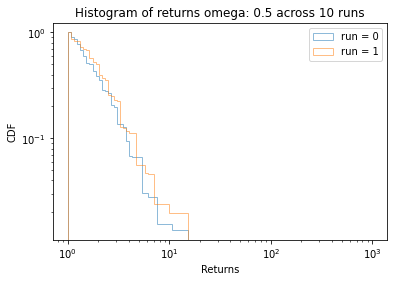

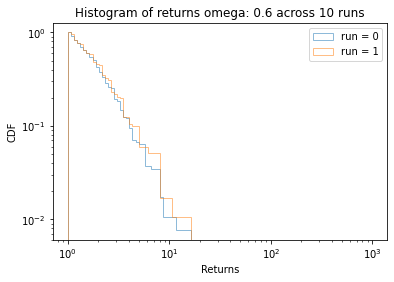

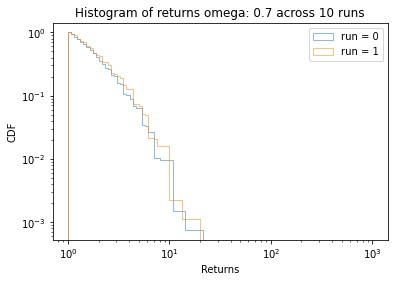

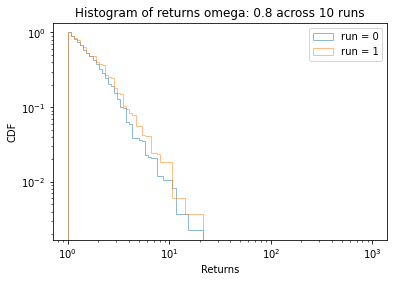

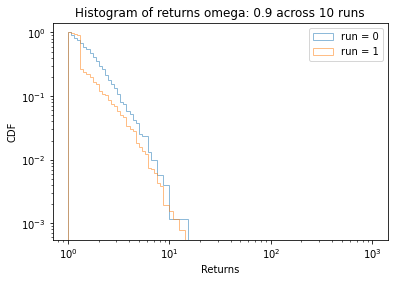

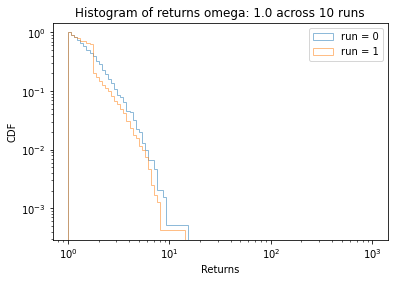

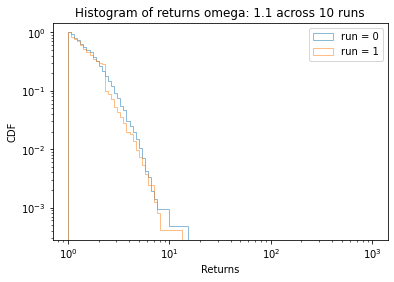

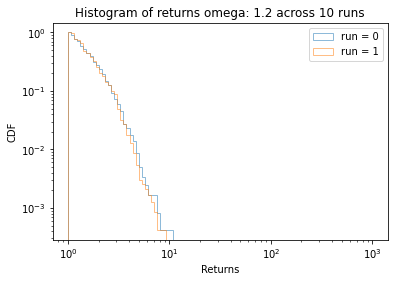

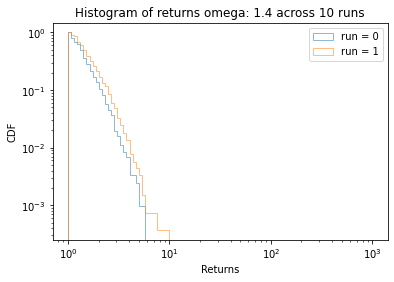

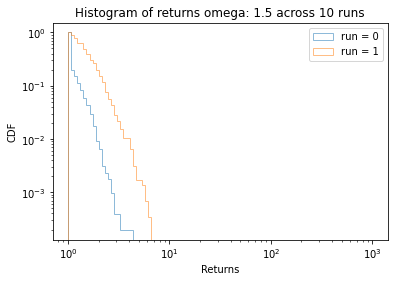

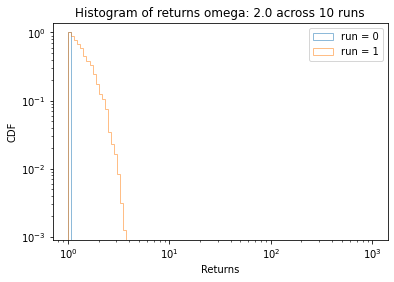

In [32]:
bins = np.logspace(0,3, 100)
for omega in range(len(omega_list)):
    for run in range(len(results_ABM_10_runs_for_different_omega[omega])):
        plt.hist(results_ABM_10_runs_for_different_omega[omega][run], bins=bins, alpha=0.5, cumulative=-1, log = True, histtype='step',label='run = ' + str(run),density=1)
        plt.gca().set_xscale("log")
        plt.title(f'Histogram of returns omega: {str(omega_list[omega])} across 10 runs')
        plt.xlabel('Returns')
        plt.ylabel('CDF')
        plt.legend()
    plt.show()

In [33]:
dict_of_results_for_different_omega = {}
for omega in range(len(omega_list)):
    HE_list_omega = []
    for run in range(len(results_ABM_10_runs_for_different_omega[omega])):
        HE_list_omega.append(Hill_estimator(results_ABM_10_runs_for_different_omega[omega][run],1))
    dict_of_results_for_different_omega[omega_list[omega]] = np.mean(HE_list_omega), np.min(HE_list_omega), np.max(HE_list_omega)

C:\Users\iChin\AppData\Local\Temp/ipykernel_30300/4134767997.py:13: RuntimeWarning:

divide by zero encountered in double_scalars



In [34]:
# making a dataframe with the mean, min and max of the Hill estimator for different values of V_f
df_ABM_return_results_for_different_omega = pd.DataFrame(dict_of_results_for_different_omega)
df_ABM_return_results_for_different_omega.index = [ 'mean', 'min', 'max']
df_ABM_return_results_for_different_omega.iloc[0:10]

,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.4,1.5,2.0
mean,1.935051,2.073567,3.240056,2.306645,2.913968,3.502910,4.006626,5.327217,4.957114,5.181240,inf
min,1.670844,1.802504,2.672981,2.262999,2.808965,3.467133,3.665215,5.084055,4.847899,4.346534,9.255072
max,2.199257,2.344629,3.807132,2.350291,3.018972,3.538687,4.348037,5.570378,5.066330,6.015945,inf


In [35]:
# saving the dataframe as a csv file
df_ABM_return_results_for_different_omega.to_csv('df_ABM_return_results_for_different_omega.csv')

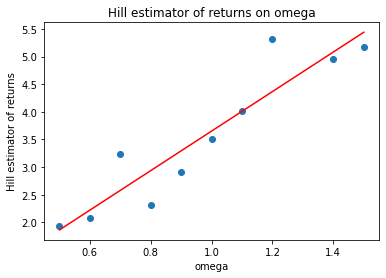

R^2: 0.8631098668949867)
intercept: 0.07413733650790855
coefficient: [3.57763097]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.00010177314088144485
Thus, we reject the null hypothesis in favor of the alternative hypothesis
However, the sample size is 10 so the results are not very reliable


In [36]:
# slicing off infinite values so the regression can run
plot_regression(omega_list[:-1], df_ABM_return_results_for_different_omega.iloc[:,:-1], 'Hill estimator of returns on omega', 'omega', 'Hill estimator of returns', variance=False)

We can see a positive relationship between omega and the Hill exponent which Fengs results also showed. A higher omega means A higher hill estimator of the tail, and thus a higher the slope of the distribution. A higher omega means a higher number of opnion groups, and thus a decreased chance of the 'herd effect' and the extreme returns that this property can induce if all traders fall in to a small number of trade groups. For example, if all agents go into 1 group and then al make the same trade return will be very extreme.
The positive relationship observed is similair to the one observed in the Feng et al paper. This is evidence in support of validity of that part of our implementation.

# ABM absolute normalized returns different V_f's across 10 runs

In [ ]:
V_f_list

In [38]:
# other parameters
n = 2**10
t = 10000
p = 0.02178
omega = 1
b = 1
size = 1
k = 1
runs = 10

In [39]:
# 10 runs, for different values of V_f
results_ABM_10_runs_for_different_V_f = []
for V_f in V_f_list:
    p = probability_of_trading(V_f, V)
    print('p: ', p)
    run_results = run_ABM(p, n, size, k, omega, b, t, runs)
    results_ABM_10_runs_for_different_V_f.append(run_results)

p:  0.02373588060133683
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
p:  0.02178293942486624
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
p:  0.019829998248395653
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
p:  0.01787705707192506
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed


In [40]:
# normalizing abs returns for each run (different n0)
abs_normalized_returns_ABM_results_for_different_V_f = []
abm_normalised_volumes_Vf = []
for V_f in range(len(V_f_list)):
    abs_normalized_returns_ABM_results_for_same_V_f = []
    abm_normalised_volumes_same_Vf = []
    for run in range(10):
        abs_normalized_returns_ABM_results_for_same_V_f.append(normalise(results_ABM_10_runs_for_different_V_f[V_f][0][run]))
        abm_normalised_volumes_same_Vf.append((results_ABM_10_runs_for_different_V_f[V_f][1][run] / np.mean(results_ABM_10_runs_for_different_V_f[V_f][1][run])))

    abs_normalized_returns_ABM_results_for_different_V_f.append(abs_normalized_returns_ABM_results_for_same_V_f)
    abm_normalised_volumes_Vf.append(abm_normalised_volumes_same_Vf)


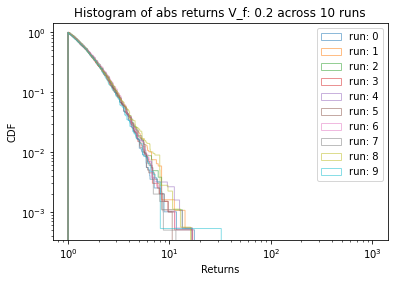

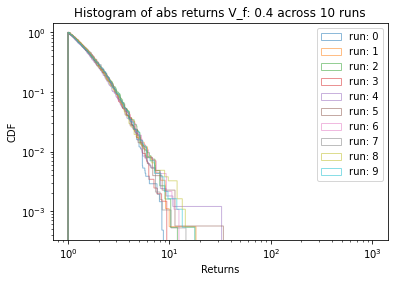

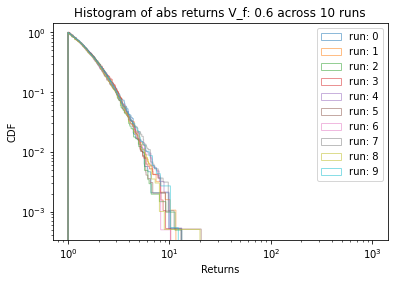

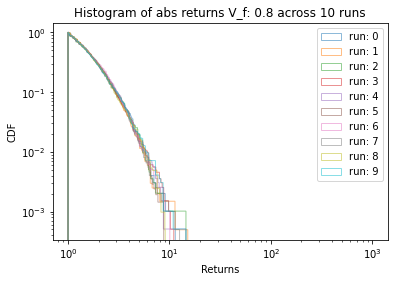

In [41]:
# plot all runs abs returns for different values of V_f on seperate histograms
bin = np.logspace(0,3, 1000)
for V_f in range(len(V_f_list)):
    for run in range(10):
        plt.hist(abs_normalized_returns_ABM_results_for_different_V_f[V_f][run], bins=bin, alpha=0.5, cumulative=-1, log = True, histtype='step',label='run: ' + str(run), density = 1)
        plt.gca().set_xscale("log")
        plt.title(f'Histogram of abs returns V_f: {str(V_f_list[V_f])} across 10 runs')
        plt.xlabel('Returns')
        plt.ylabel('CDF')
        plt.legend()
    plt.show()

In [42]:
# making a dictionary with the mean, min and max of the Hill estimator of abs return distribution for different values of V_f
dict_of_results_for_different_V_f = {}
for V_f in range(len(V_f_list)):
    HE_list_V_f = []
    for run in range(10):
        HE_list_V_f.append(Hill_estimator(abs_normalized_returns_ABM_results_for_different_V_f[V_f][run], 1))
    dict_of_results_for_different_V_f[V_f_list[V_f]] = np.mean(HE_list_V_f), np.min(HE_list_V_f), np.max(HE_list_V_f)

In [ ]:
dict_of_results_for_different_V_fzzz

In [44]:
# making a dataframe with the mean, min and max of the Hill estimator of abs return distribution for different values of V_f
df_ABM_abs_return_results_for_different_V_F = pd.DataFrame(dict_of_results_for_different_V_f)
df_ABM_abs_return_results_for_different_V_F.index = [ 'mean', 'min', 'max']
df_ABM_abs_return_results_for_different_V_F

,0.2,0.4,0.6,0.8
mean,3.695395,3.445256,3.844946,3.816627
min,3.097253,2.963892,3.146710,3.471308
max,4.100740,4.546234,5.111560,4.299661


In [45]:
# saving the dataframe as a csv file
df_ABM_abs_return_results_for_different_V_F.to_csv('df_ABM_results_for_different_V_F.csv')


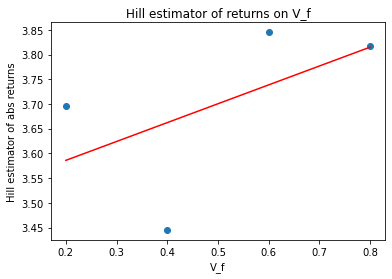

R^2: 0.2927682379087606)
intercept: 3.509709598193037
coefficient: [0.38169291]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.4589193794740376
Thus, we fail to reject the null hypothesis


In [46]:
plot_regression(V_f_list, df_ABM_abs_return_results_for_different_V_F, title='Hill estimator of returns on V_f', x_label='V_f', y_label='Hill estimator of abs returns', variance=False)

Here, we can see there is not a clear linear relationship between the value of V_f and the Hills estimator of the tail of the return distribution.
The interpretation of this parameter is the proportion of fundamental traders on the market, which following Fengs evidence trade less. In effect a lower C_f means a higher probability of trading, as technical traders have a higher trading velocity.
Interpreting this, it means the tail of the absolute return distribution both frequent (high p) and infrequent trading (low p) trading. This is the same as Feng et. al's paper and again is evidence in support of the validity of our implementation.

# ABM return results for different n0's across 10 runs

In [47]:
# anchor

In [48]:
# other parameters
n = 2**10
t = 10**6
p = 0.02178
omega = 1
b = 1
size = 1
k = 1
runs = 10

In [51]:
n0_list = [2**8, 2**10, 2**12, 2**14]

In [52]:
t = 10**4
# 10 runs, for different values of n0 (number of agents), using V_f = 0.4
results_ABM_10_runs_for_different_n0 = []
p = probability_of_trading(0.4, V)
for n0 in n0_list:
    print(n0)
    results_ABM_10_runs_for_different_n0.append(run_ABM(p, int(n0), size, k, omega, b, t, runs))

256
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
1024
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
4096
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
16384
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed


In [53]:
# normalizing abs returns for each run (different n0)
abs_normalized_returns_ABM_results_for_different_n0 = []
volumes_abm_for_different_n0 = []
for n0 in range(len(n0_list)):
    abs_normalized_returns_ABM_results_for_same_n0 = []
    volumes_abm_for_same_n0 = []
    for run in range(10):
        abs_normalized_returns_ABM_results_for_same_n0.append(normalise((results_ABM_10_runs_for_different_n0[n0][0][run])))
        volumes_abm_for_same_n0.append((results_ABM_10_runs_for_different_n0[n0][1][run] / np.mean(results_ABM_10_runs_for_different_n0[n0][1][run])))

    abs_normalized_returns_ABM_results_for_different_n0.append(abs_normalized_returns_ABM_results_for_same_n0)
    volumes_abm_for_different_n0.append(volumes_abm_for_same_n0)

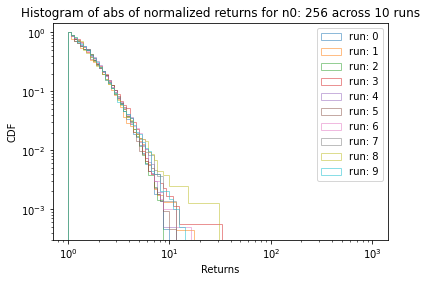

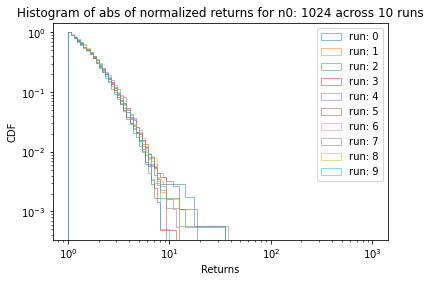

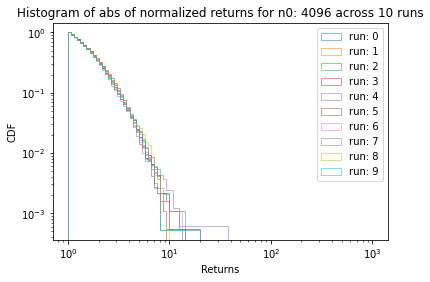

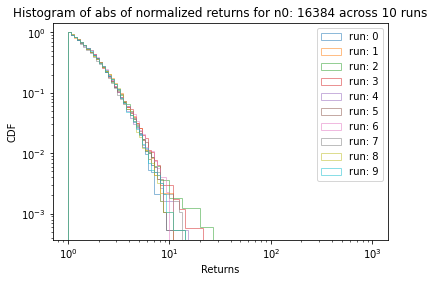

In [54]:
# plot all runs abs returns for different values of V_f on seperate histograms
bins = np.logspace(0,3, 100)
for n0 in range(len(n0_list)):
    for run in range(10):
        plt.hist(abs_normalized_returns_ABM_results_for_different_n0[n0][run], bins=bins, alpha=0.5, cumulative=-1, log = True, histtype='step',label= 'run: ' + str(run), density = 1)
        plt.gca().set_xscale("log")
        plt.title(f'Histogram of abs of normalized returns for n0: {str(n0_list[n0])} across 10 runs')
        plt.xlabel('Returns')
        plt.ylabel('CDF')
        plt.legend()
    plt.show()

In [55]:
dict_of_results_for_different_n0 = {}
for n0 in range(len(n0_list)):
    HE_list_n0= []
    for run in range(10):
        HE_list_n0.append(Hill_estimator(abs_normalized_returns_ABM_results_for_different_n0[n0][run].flatten(),1))
    dict_of_results_for_different_n0[n0_list[n0]] = np.mean(HE_list_n0), np.min(HE_list_n0), np.max(HE_list_n0)

In [56]:
dict_of_results_for_different_n0

{256: (3.6294567935348865, 2.7897057867437103, 4.580329205848681),
 1024: (3.638980207537389, 3.2230410686125497, 4.164614781620289),
 4096: (3.856986459379173, 3.1685720142539515, 4.84896460605938),
 16384: (3.5765961460340634, 2.968532577529259, 4.02293042438984)}

In [57]:
# making a dataframe with the mean, min and max of the Hill estimator of abs return distribution for different values of V_f
df_ABM_normalized_abs_return_results_for_different_n0 = pd.DataFrame(dict_of_results_for_different_n0)
df_ABM_normalized_abs_return_results_for_different_n0.index = [ 'mean', 'min', 'max']
df_ABM_normalized_abs_return_results_for_different_n0

,256,1024,4096,16384
mean,3.629457,3.638980,3.856986,3.576596
min,2.789706,3.223041,3.168572,2.968533
max,4.580329,4.164615,4.848965,4.022930


In [58]:
# saving the dataframe as a csv file
df_ABM_normalized_abs_return_results_for_different_n0.to_csv('df_ABM_normalized_abs_return_results_for_different_V_F.csv')

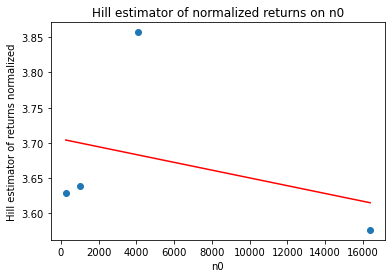

R^2: 0.1106592121629395)
intercept: 3.705509895965373
coefficient: [-5.51562396e-06]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.667345205711779
Thus, we fail to reject the null hypothesis


In [59]:
# Regression on linear scale
plot_regression(n0_list, df_ABM_normalized_abs_return_results_for_different_n0, 'Hill estimator of normalized returns on n0', 'n0', 'Hill estimator of returns normalized', variance=False)


Here, we can also see there is no clear  linear relationship between higher values of n0. 
The interpretation of this parameter is the amount of agents trading in the simulation.
Interpreting this, it means the tail of the absolute return distribution is not significantly affected by the number of agents.
 This is the same as Feng et. al's paper and again is evidence in support of the validity of our implementation.

### Concluding:
The ABM model seems to show the same relationships of n0, V_f and omega parameters that Feng et al. found in their 2012 paper.

# Stochastic model run

In [60]:
# other parameters
n = 2**10
t = 10**4
p = 0.02178
omega = 1
b = 1
size = 1
k = 1
M = 500
d = 1.12
runs = 10
init = 1

In [61]:
V_f_list = [0.2, 0.4, 0.6, 0.8]



In [62]:
# stochastic model without time horizon
stochastic_model_without_time_horizon_results = []
for V_f in V_f_list:
    p = probability_of_trading(V_f, V)
    result = run_Stochastic_Model(n = n, p = p, init = 1, time_horizon= False, M=M, d=d, t=t, runs=runs)
    normalised_result = []
    for run in result:
        normalised = normalise(run)
        normalised_result.append(normalised)
    stochastic_model_without_time_horizon_results.append(normalised_result)

Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed


In [63]:
# stochastic model with time horizon
stochastic_model_with_time_horizon_results = []
for V_f in V_f_list:
    p = probability_of_trading(V_f, V)
    print('V_f:', V_f)
    result = run_Stochastic_Model(n = n, p = p, init = 1, time_horizon= True, M=M, d=d, t=t, runs=runs)
    normalised_result = []
    for run in result:
        normalised = normalise(run)
        normalised_result.append(normalised)
    stochastic_model_with_time_horizon_results.append(normalised_result)

V_f: 0.2
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
V_f: 0.4
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
V_f: 0.6
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
V_f: 0.8
Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed


# Model validation

This section consists two parts: 
1) comparing the simulated daily return data vs. the empirical daily return data + relevant plots & statistical tests
2) comparing the simulated daily trading volume data vs. the empirical trading volume data + relevant plots & statistical tests

#### Notes on the dataset



Data is obtained from the period 2013-2022 (10 years), while Feng et al's (2012) compared their simulated results to empirical data from the 10 year period from 1997-2006.

Some notable remarks on comparison between the datasets:

* Feng et al. considered the S&P 500, but only stocks listed for the entire period, which were 307, in our case we had 463 stocks, a notable increase.
* We obtained volume and shares outstanding data from Compustat database via WRDS, while obtaining open and closing data from Yahoo finance while Feng et al obtained all these variables from the compustat database.
* Where volume, sharesoutsanding, open or close data was missing for a certain day, we imputed the values using a backfill method. If a stock was unlisted, this caused 0's in the dataset for the days it was unlisted, which might bias the data.




### 1.  Comparing simulated daily resturn vs. real stock daily return data

#### Importing real stock data

In [64]:
df_open_clean = pd.read_csv('data/df_opening_SnP500_39_years_clean.csv', parse_dates=True, index_col='Date')
df_close_clean = pd.read_csv('data/df_closing_SnP500_39_years_clean.csv', parse_dates=True, index_col='Date')
df_open_clean = df_open_clean.drop(columns ='Date.1')
df_close_clean = df_close_clean.drop(columns ='Date.1')

In [65]:
df_open_clean = pd.read_csv('data/df_open_clean.csv', parse_dates=True, index_col='Date')
df_close_clean = pd.read_csv('data/df_close_clean.csv', parse_dates=True, index_col='Date')
df_open_clean = df_open_clean.drop(columns ='Index')
df_close_clean = df_close_clean.drop(columns ='Index')

In [66]:
assert df_open_clean.index.dtype == 'datetime64[ns]'
assert df_close_clean.index.dtype == 'datetime64[ns]'

In [67]:
df_open_clean.columns

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACGL', 'ACN', 'ADBE',
       ...
       'WY', 'WYNN', 'XEL', 'XOM', 'XRAY', 'XYL', 'YUM', 'ZBH', 'ZBRA',
       'ZION'],
      dtype='object', length=463)

In [68]:
# calculation of returns following feng et al. (2012) method:
df_real_returns_log_difference = df_open_clean.apply(np.log) - df_close_clean.apply(np.log) 

# normalising the returns
df_real_returns_log_difference = (df_real_returns_log_difference - df_real_returns_log_difference.mean()) / df_real_returns_log_difference.std()

# taking absolute of real returns
df_real_returns_log_difference_abs = df_real_returns_log_difference.abs()

In [69]:
# Flattening dataframes
real_returns_log_difference_abs_flattened = df_real_returns_log_difference_abs.values.flatten()

In [70]:
sorted_log = sorted(real_returns_log_difference_abs_flattened)

Next we get the hills estimator of the real data, and some other summary statistics. Using the relationships we established, we try to select the parameters to get the best fit.

In [71]:
# Getting the hills estimator
Hill_estimator(sorted_log,1)

3.7192999721928612

In [72]:
# restating the found Hill estimates for different values of omega on previous runs estimated at the beginning of the notebook
df_ABM_return_results_for_different_omega

,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.4,1.5,2.0
mean,1.935051,2.073567,3.240056,2.306645,2.913968,3.502910,4.006626,5.327217,4.957114,5.181240,inf
min,1.670844,1.802504,2.672981,2.262999,2.808965,3.467133,3.665215,5.084055,4.847899,4.346534,9.255072
max,2.199257,2.344629,3.807132,2.350291,3.018972,3.538687,4.348037,5.570378,5.066330,6.015945,inf


This is the hills estimate of the power law tail of the empirical data, Compared to the above table would suggest an omega of 1 would be a good fit for the data, similar to fengs Findings. It should be noted that the hills estimator is not very reliable, and very dependent on the choice of the tail region which is a researcher choice.

# Comparing 10 runs vs. empirical data

In [73]:
# anchor plot

In [74]:
# Get bin x and y values for each dataset
def get_bins(data_list, bin):
    list_of_bin_heights = []
    list_of_bin_edges = []

    for dataset in data_list:
        binheights, bin_edges, patches = plt.hist(dataset, bins=bin, cumulative=-1, density=True, log=True, histtype='step', alpha = 0.5)
        list_of_bin_heights.append(binheights)
        list_of_bin_edges.append(bin_edges)

    mean_x = np.mean(list_of_bin_edges, axis = 0)
    std_x = np.std(list_of_bin_edges, axis = 0)
    x_axis = [mean_x, std_x]

    mean_y = np.mean(list_of_bin_heights, axis = 0)
    std_y = np.std(list_of_bin_heights, axis = 0)
    y_axis = [mean_y, std_y]

    return x_axis, y_axis

## Aggregating run results & numerical expirimentation

We tried various parameter settings to manually fit the ABM model,

Feng et als parameters werere

V_f =  0.4
b = 1
k = 1
omega = 1
n0_list = 2^10


In general, we observed the relationships mentioned in the first part of the notebook. 
When varying multiple parameters, other parameters were also varied to examine their effect.
We do not go into much detail about the effects of these of these fit do to timeconstraions, and we did not achieve a better fit then the one we got with Feng's parameters initial parameters, therefor we dont plot them. but we do provide a short description below and also the individual run variable which can be indexed to show the fits.


During this numerical expirimentation, we also developed some for the following interrelationships & parameter effects. These are not results, just intuitions which could be further explored in future research.

We found k increases the variance in the returns, which is logical as is it factors the returns.
We found b (which is basically volatility in the number of opinion groups) increases the fatness of the tail of the distribution
We found the n setting of n0 = 2^16,(contrary to Fengs findings, which did not report n0 = 2^16) sometimes increased maxmimum returns and thus the fat tailed in the distribution especially with high omega.

This can be explained if you think of it from a behavioral standpoint, namely that a higher number of agents, if every agent makes the same trade, can lead to a more extreme return, as a return is basicaly a mismatch of demand and supply in this ABM model, the chance of this happening can increase with a lower number of opninion groups (higher omega))

To compare the results of some of the numerical experiments against the empirical data, one can uncomment the relevant code and index the variable below


Indexing works as follows:

run_variable[ index of parameter setting ]


Recall the diferent parameter settings:

V_f_list = [0.2, 0.4, 0.6, 0.8]

n0_list = [2^6, 2^8, 2^10, 2^12]


For example, if we want V_f setting 0.8, we uncomment the code at: 

'# uncomment this code to look at fits for multiple values of n0 for the ABM model'


then:

abs_normalized_returns_ABM_results_for_different_V_f[3]

because V_f = 0.8 is the 3rd element of V_f_list



Then run the 'Figure code' below and it to plot results

In [75]:
# Return fit
bin=np.logspace(start=0, stop=np.log(10), num=100)

# uncomment this code to look at fits for multiple values of n0 for the ABM model

# abm_x = get_bins(abs_normalized_returns_ABM_results_for_different_n0[0], bin)[0][0]
# abm_y = get_bins(abs_normalized_returns_ABM_results_for_different_n0[0], bin)[1][0]
# abm_y_error = get_bins(abs_normalized_returns_ABM_results_for_different_n0[0], bin)[1][1]

## uncomment this code to look at fits for multiple values of V_F for the ABM model
# abm_x = get_bins(abs_normalized_returns_ABM_results_for_different_V_f[1], bin)[0][0]
# abm_y = get_bins(abs_normalized_returns_ABM_results_for_different_V_f[1], bin)[1][0]
# abm_y_error = get_bins(abs_normalized_returns_ABM_results_for_different_V_f[1], bin)[1][1]

## uncomment this code to look at fits for multiple values of omega for the ABM model

# abm_x = get_bins(results_ABM_10_runs_for_different_omega[1], bin)[0][0]
# abm_y = get_bins(results_ABM_10_runs_for_different_omega[1], bin)[1][0]
# abm_y_error = get_bins(results_ABM_10_runs_for_different_omega[1], bin)[1][1]

abm_x = get_bins(results_ABM_10_runs_for_different_omega[0], bin)[0][0]
abm_y = get_bins(results_ABM_10_runs_for_different_omega[0], bin)[1][0]
abm_y_error = get_bins(results_ABM_10_runs_for_different_omega[0], bin)[1][1]

# ## uncomment this code to look at fits for multiple values of omega for the Stochastic model

stoch_x = get_bins(stochastic_model_without_time_horizon_results[1], bin)[0][0]
stoch_y = get_bins(stochastic_model_without_time_horizon_results[1], bin)[1][0]
stoch_y_error = get_bins(stochastic_model_without_time_horizon_results[1], bin)[1][1]

stoch_hoz_x = get_bins(stochastic_model_with_time_horizon_results[1], bin)[0][0]
stoch_hoz_y = get_bins(stochastic_model_with_time_horizon_results[1], bin)[1][0]
stoch_hoz_y_error = get_bins(stochastic_model_with_time_horizon_results[1], bin)[1][1]

# this is only here so the hists dont get plotted, but we can extract the binheights
plt.close()

### Figure Code

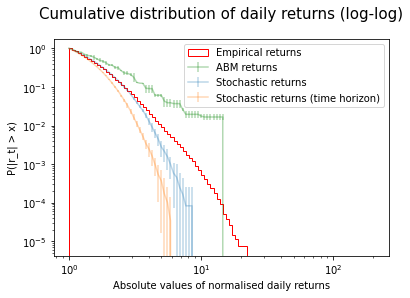

In [76]:
# figure code
plt.figure(1)
plt.title('Cumulative distribution of daily returns (log-log)', fontsize=15, pad=20)
plt.hist(sorted_log, bins=bin, alpha=1, cumulative=-1, density=True, log = True, histtype='step', label="Empirical returns", color='red')
plt.errorbar(abm_x[:-1], abm_y,alpha=0.3, yerr= abm_y_error, label = 'ABM returns', color='green')
plt.errorbar(stoch_x[:-1], stoch_y, yerr=stoch_y_error, alpha=0.3, label = 'Stochastic returns')
plt.errorbar(stoch_hoz_x[:-1], stoch_hoz_y, yerr=stoch_hoz_y_error, alpha=0.3, label = 'Stochastic returns (time horizon)')
plt.xlabel("Absolute values of normalised daily returns")
plt.ylabel("P(|r_t| > x)")
plt.legend()
plt.gca().set_xscale("log")
plt.show()

Here we can see the quality of fit, with average bin heights across 10 runs plotted including error bars. The ABM model seems to be the best fit for the fat tail property of the data, although the trail of the distribution is not as fat as the empirical one. Also the ABM model overshoots on the lower return values where the stochastic models are a better fit there, although undershooting a bit.
Stochastic models seem to perform worse in the fat tail department, with the stochastic model with time horizons being the worst of the two. This might indicate the assumption that d (which stands for the decay on the lookback function of investors) was unchanged since Fengs time, or some other question of parameter calibration.
Due to time contraints, we dont have any more time to experiment with parameters of the models, so we will leave that for future researchers.

# Analysis on the fit of the returns

### RMSE

In [77]:
def RMSE(predictions:list[float], targets:list[float]) -> float:
    '''Returns the root mean squared error between predictions and target values as a float'''
    return math.sqrt(np.mean([(targets[i] - predictions[i]) ** 2 for i in range(len(targets))]))

In [78]:
# this code is to get the binheights
mean_bin_heights = [abm_y, stoch_y, stoch_hoz_y]
data_bins, x, _ = plt.hist(sorted_log, bins=bin, cumulative=-1, density=True, log=True)
plt.close()

In [79]:
labels = [ 'ABM returns', 'Stochastic returns', 'Stochastic returns (time horizon)']
for result in range(len(mean_bin_heights)):
    results_bin_height = mean_bin_heights[result]
    print(f'RMSE: {labels[result]}: ', RMSE(results_bin_height, data_bins))


RMSE: ABM returns:  0.07051870594372937
RMSE: Stochastic returns:  0.012815190955559493
RMSE: Stochastic returns (time horizon):  0.019614871120464887


We can see the agent based model seems to have the least error, however, what should be noted is that the bin heights are from a plot which is log scaled on the y axis, meaning error in the upward direction will not have an equal weight to the error in another direction. The mean square error does weigh error in both directions equally, so please consider this when interpreting results. 
We therefore also plot the residuals with the sign, to show the directionality of the residuals and the specific bin in which the error occured.

In [80]:
def residuals(predictions:list[float], targets:list[float]) -> list[float]:
    '''Returns the residuals between predictions and target values as a list of floats'''
    return np.array(targets) - np.array(predictions)

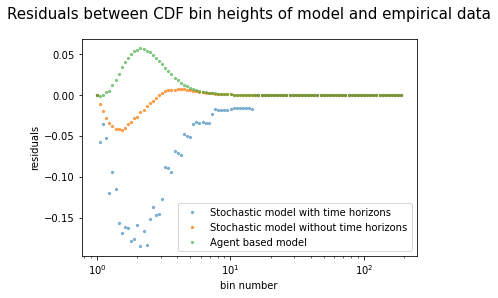

In [81]:
# plot residuals as a scatter plot
residuals_stoch_horizons = residuals(mean_bin_heights[0], data_bins)
residuals_stoch = residuals(mean_bin_heights[1], data_bins)
residuals_ABM = residuals(mean_bin_heights[2], data_bins)

plt.scatter(stoch_hoz_x[:-1], residuals_stoch_horizons, label = 'Stochastic model with time horizons', alpha = 0.5, s=5)
plt.scatter(stoch_x[:-1], residuals_stoch, label = 'Stochastic model without time horizons', alpha = 0.7, s=5)
plt.scatter(abm_x[:-1], residuals_ABM, label = 'Agent based model', alpha = 0.5, s=5)
plt.xlabel("bin number")
plt.ylabel("residuals")
plt.title('Residuals between CDF bin heights of model and empirical data', fontsize=15, pad=20)
plt.gca().set_xscale("log")
plt.legend()
plt.show()

Interpreting the results of these residuals, we can see that the residuals converge to zero when the cumulative probability aproaches one (which can can be seen when the number of bins on the x axis aproaches the number of bins on the histogram).
Also, we can see that for the lower bin numbers, which represent the left  part of the cumulative distribution function and thus the fat tail, the fit is best for the ABM model. Also the error for the model without time horizons seems to be less extreme than the error of the model with time horizons. 


## Longer timestep run vs. empirical data

In [82]:
# other parameters
n = 2**10
t = 10**6
p = 0.02178
omega = 1
b = 1
size = 1
k = 1
M = 500
d = 1.12

The data has 1.15* 10**6  daily return & volume samples, so now we will run a longer simulation with more timesteps



Model: self, p: float, n: int, size: int, k: int, omega: int, b: int)

Stochastic_Model(self, n: int, p: float, init: int, time_horizon: bool, M, d)

In [83]:
empirical_return_data = sorted_log

In [84]:

ks_abm = Model(p, n, 1, k, omega, b)
for i in range(t):
    ks_abm.step()

abm_returns = normalise(ks_abm.daily_returns)
abm_volumes = ks_abm.daily_trading_volumes

ks_stoch = Stochastic_Model(p, n, 1, False, M, d)
for i in range(t):
    ks_stoch.step()

stoch_returns = normalise(ks_stoch.returns)

ks_stoch_horizon = Stochastic_Model(p, n, 1, True, M, d)
for i in range(t):
    ks_stoch_horizon.step()

stoch_horizon_returns = normalise(ks_stoch_horizon.returns)

In [85]:
return_datasets = [stoch_returns, stoch_horizon_returns, abm_returns, empirical_return_data]
labels = ['Stochastic model', 'Stochastic model with time horizon', 'Agent based model', 'Empirical data']

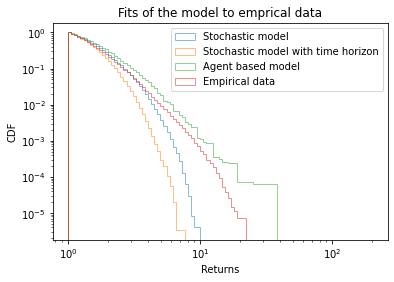

In [86]:
bin=np.logspace(start=0, stop=np.log(10), num=100)
for index in range(len(return_datasets)):
        plt.hist(return_datasets[index], bins=bin, alpha=0.5, cumulative=-1, log = True, histtype='step',label=labels[index],density=1)
        plt.gca().set_xscale("log")
        plt.title(f'Fits of the model to emprical data')
        plt.xlabel('Returns')
        plt.ylabel('CDF')
        plt.legend()
plt.show()

In [87]:
# code for kolmogorov-smirnov test for similarity of distributions: reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
# assumed samples are independent

# making a matrix in which ks test results will be visualised

array_for_ks_test_results = np.zeros(((len(return_datasets), len(return_datasets))))
for i in range(len(return_datasets)):
    for j in range(len(return_datasets)):
        # returning the 1st element of ks test result as this is the p-value of the ks test
        # print(stats.kstest(return_datasets[i], return_datasets[j])[1])
            array_for_ks_test_results[i,j] = stats.kstest(return_datasets[i], return_datasets[j])[1]

In [88]:
# here the p values of the ks test are visualised in a dataframe
df_of_kstest_results = pd.DataFrame(array_for_ks_test_results)
df_of_kstest_results

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0


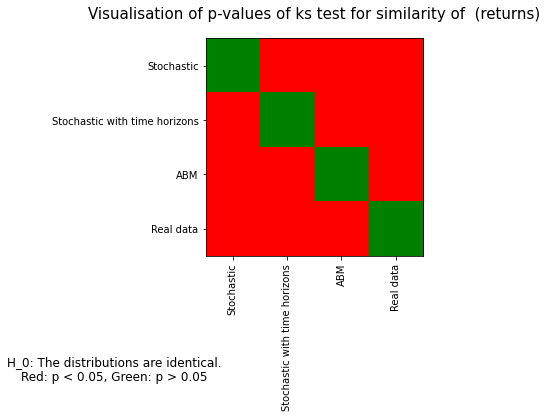

In [89]:
color_matrix = np.where(array_for_ks_test_results < 0.05, 0,1)
cmap = (mpl.colors.ListedColormap(['red', 'green']))
plt.imshow(color_matrix, cmap=cmap, vmin=0, vmax=1)
plt.xticks([0,1,2,3], ['Stochastic', 'Stochastic with time horizons', 'ABM', 'Real data'], rotation = 90)
plt.yticks([0,1,2,3], ['Stochastic', 'Stochastic with time horizons', 'ABM', 'Real data'])
plt.title("Visualisation of p-values of ks test for similarity of  (returns)", fontsize=15, pad=20)
plt.figtext(0.05, -0.3, "H_0: The distributions are identical.\nRed: p < 0.05, Green: p > 0.05", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

We can see, even though the simulated distributions look similair on the plot. We rejected KS test null hypothesis that the two samples come from identical distributions at significance level of 0.05 for each model.



## 2. Simulated vs. empirical trading volume data

#### Importing & Normalizing empirical volume data

In [90]:
df_volume_clean_wrds = pd.read_csv('data/df_volume_clean_wrds.csv', parse_dates = True, index_col=0)
df_volume_clean_wrds.drop(columns=['Date.1'],inplace = True)
assert 'Date.1' not in df_volume_clean_wrds
assert df_volume_clean_wrds.index.dtype == 'datetime64[ns]'

In [91]:
empirical_volume_data = df_volume_clean_wrds

In [92]:
def normalize_stocks_volume_per_year(df1):
    '''Returns a dataframe with the normalized volume of stocks per year'''
    yearly_mean_volume = df1.resample('Y').mean()
    for i in yearly_mean_volume.index:
        for j in yearly_mean_volume.columns:
            year = i.year
            mask = df1.index.year == year
            df1.loc[mask,j] = df1.loc[mask,j]/yearly_mean_volume.loc[i,j]
    return df1

In [93]:
# to test this function, we can check if the mean of the normalized volume per year is 1
empirical_volume_data.resample('Y').mean()
# looks good

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-31,3.045449e+06,4.131149e+07,7.816195e+05,1.445025e+07,6.257611e+06,1.990433e+06,8.060460e+06,4.436165e+05,3.099721e+06,3.592994e+06,...,4.695080e+06,1.250706e+06,3.301607e+06,1.262712e+07,7.688385e+05,1.255856e+06,3.634615e+06,1.054791e+06,174106.337302,2.078601e+06
2014-12-31,2.272985e+06,1.238078e+07,7.949913e+05,3.452680e+07,9.130938e+06,1.698106e+06,6.013064e+06,5.164888e+05,2.799480e+06,3.354736e+06,...,4.641452e+06,1.795404e+06,2.740702e+06,1.172101e+07,8.334123e+05,1.013436e+06,3.152440e+06,1.237488e+06,471274.000000,2.466435e+06
2015-12-31,2.559315e+06,1.153099e+07,1.059096e+06,5.164626e+07,1.046825e+07,2.043598e+06,5.817286e+06,4.519217e+05,2.481861e+06,2.791614e+06,...,3.727376e+06,3.208687e+06,3.302383e+06,1.406299e+07,9.482419e+05,1.137982e+06,4.075438e+06,1.231677e+06,530913.865079,2.707760e+06
2016-12-31,2.081338e+06,9.160580e+06,1.033338e+06,3.826767e+07,7.995381e+06,2.543463e+06,9.061932e+06,3.796295e+05,2.555518e+06,2.822106e+06,...,4.968402e+06,3.417733e+06,3.267105e+06,1.239459e+07,1.649353e+06,1.312734e+06,3.469905e+06,1.571417e+06,648893.698413,3.363428e+06
2017-12-31,1.846746e+06,5.862530e+06,1.657572e+06,2.700270e+07,5.967196e+06,1.785437e+06,6.598606e+06,4.590920e+05,2.114190e+06,2.460035e+06,...,3.253748e+06,1.987586e+06,2.628906e+06,1.090880e+07,1.621055e+06,1.178522e+06,2.142878e+06,1.359164e+06,328787.872510,2.478809e+06
2018-12-31,2.544049e+06,6.842145e+06,1.142888e+06,3.376838e+07,7.019459e+06,1.546483e+06,6.179530e+06,9.331440e+05,2.235993e+06,3.259894e+06,...,4.486538e+06,3.151586e+06,3.682863e+06,1.348126e+07,2.712300e+06,1.103273e+06,2.110327e+06,1.193503e+06,402520.378486,2.351557e+06
2019-12-31,2.149770e+06,6.974919e+06,1.125318e+06,2.794224e+07,7.814414e+06,1.326785e+06,5.144075e+06,1.241748e+06,1.851884e+06,2.651977e+06,...,4.126360e+06,2.032719e+06,3.203835e+06,1.159706e+07,1.669033e+06,8.411636e+05,1.710212e+06,1.133707e+06,558678.773810,2.232458e+06
2020-12-31,1.849400e+06,6.772373e+07,9.835181e+05,7.297082e+07,9.429728e+06,1.288009e+06,6.686208e+06,2.038213e+06,2.315411e+06,3.065785e+06,...,5.043295e+06,4.745901e+06,3.070552e+06,2.876056e+07,1.803349e+06,1.169193e+06,2.150342e+06,1.376043e+06,407713.592885,2.556167e+06
2021-12-31,1.619945e+06,3.812482e+07,7.704331e+05,9.012147e+07,6.804253e+06,9.788828e+05,5.343656e+06,2.040180e+06,1.987258e+06,2.365483e+06,...,4.343849e+06,3.344809e+06,2.941258e+06,2.387800e+07,1.500157e+06,8.670148e+05,1.538044e+06,1.373060e+06,279893.392857,1.330721e+06


the paper used parameters: V_f = 0.4, b = 1.0 and n0 = 2**10


In [94]:
# we will now index the previous results to find the 10 runs that adhere to this parameter settings, we will reiterare the relevant indexers for clarity.
# slicing syntax for the results object is as follows: results_ABM_10_runs[index of desired V_f value in V_f list][0 for returns, 1 for volume][index of desired run in range(10)]

# the 10 runs are for V_f_list carries the following values: [0.2, 0.4, 0.6, 0.8]
# n0 = 2**10 is held constant for all V_f runs
# b = 1.0 is also held constant across all V_f runs

In [95]:
empirical_volume_data_flattened_across_stocks = empirical_volume_data.values.flatten()

In [96]:
# Return volume
bin=np.logspace(start=0, stop=np.log(10), num=100)


# uncomment this code to look at fits for multiple values of n0 for the ABM model
# abm_x = get_bins(volumes_abm_for_different_n0[1], bin)[0][0]
# abm_y = get_bins(volumes_abm_for_different_n0[1], bin)[1][0]
# abm_y_error = get_bins(volumes_abm_for_different_n0[1], bin)[1][1]


# uncomment this code to look at fits for multiple values of omega for the ABM model
# abm_x = get_bins(volumes_ABM_10_runs_for_different_omega[1], bin)[0][0]
# abm_y = get_bins(volumes_ABM_10_runs_for_different_omega[1], bin)[1][0]
# abm_y_error = get_bins(volumes_ABM_10_runs_for_different_omega[1], bin)[1][1]

# uncomment this code to look at fits for multiple values of V_F for the ABM model
abm_x = get_bins(abm_normalised_volumes_Vf[1], bin)[0][0]
abm_y = get_bins(abm_normalised_volumes_Vf[1], bin)[1][0]
abm_y_error = get_bins(abm_normalised_volumes_Vf[1], bin)[1][1]

# this is only here so the hists dont get plotted, but we can extract the binheights
plt.close()

C:\Anaconda\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide



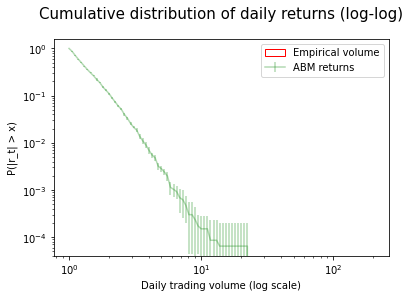

In [97]:
# figure code
plt.figure(1)
plt.title('Cumulative distribution of daily returns (log-log)', fontsize=15, pad=20)
plt.hist(empirical_volume_data_flattened_across_stocks, bins=bin, alpha=1, cumulative=-1, density=True, log = True, histtype='step', label="Empirical volume", color='red')
plt.errorbar(abm_x[:-1], abm_y,alpha=0.3, yerr= abm_y_error, label = 'ABM returns', color='green')
plt.xlabel("Daily trading volume (log scale)")
plt.ylabel("P(|r_t| > x)")
plt.legend()
plt.gca().set_xscale("log")
plt.show()

In [98]:
# this code is to get the binheights
mean_bin_heights = [abm_y, stoch_y, stoch_hoz_y]
data_bins, x, _ = plt.hist(sorted_log, bins=bin, cumulative=-1, density=True, log=True)
plt.close()
labels = [ 'ABM returns', 'Stochastic returns', 'Stochastic returns (time horizon)']
for result in range(len(mean_bin_heights)):
    results_bin_height = mean_bin_heights[result]
    print(f'RMSE: {labels[result]}: ', RMSE(results_bin_height, data_bins))


RMSE: ABM returns:  0.05797076666442342
RMSE: Stochastic returns:  0.012815190955559493
RMSE: Stochastic returns (time horizon):  0.019614871120464887


C:\Anaconda\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide



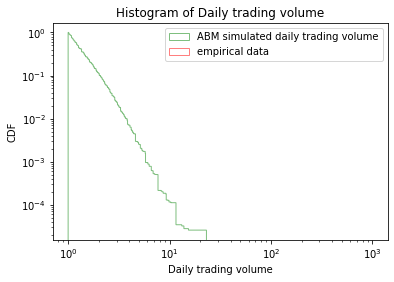

In [99]:
bins = np.logspace(0,3, 1000)
normalized_volume_abm = abm_volumes/np.mean(abm_volumes)
plt.hist(normalized_volume_abm, bins=bins, alpha=0.5, cumulative=-1, log = True, histtype='step',label= 'ABM simulated daily trading volume' ,density=1, color = 'green')
plt.gca().set_xscale("log")
plt.title(f'Histogram of Daily trading volume')
plt.xlabel('Daily trading volume')
plt.ylabel('CDF')
plt.hist(empirical_volume_data_flattened_across_stocks, bins=bins, alpha=0.5, cumulative=-1, log = True, histtype='step',label= 'empirical data',density=1, color = 'red')
plt.legend()
plt.show()

In [100]:
bins_abm_vol_heights, bins, _ = plt.hist(normalized_volume_abm, bins=bins, alpha=0.5, cumulative=-1, log = True, histtype='step',label= 'ABM simulated daily trading volume' ,density=1, color = 'green')
bins_empirical_vol, bins, _ = plt.hist(empirical_volume_data_flattened_across_stocks, bins=bins, alpha=0.5, cumulative=-1, log = True, histtype='step',label= 'empirical data',density=1, color = 'red')
plt.close()

C:\Anaconda\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide



# Analysis on the fit of the volume
### RMSE

Next, we will look at RMSE, although we can see the distributions are different, this can be usefull for quantifying quality of fit using mutiple parameters settings.

Since the number of samples is different, we will use RMSE on the binheights of the CDFs to compare the two distributions. Althrough it is not a very stringent test, it atleast allows for a rough comparison of dsitribution shape fit.


In [101]:
RMSE(bins_abm_vol_heights, bins_empirical_vol)

nan

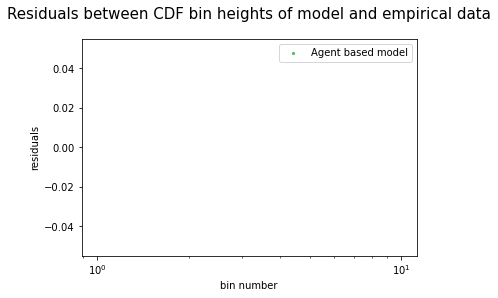

In [102]:
plt.scatter(bins[:-1], residuals(bins_abm_vol_heights, bins_empirical_vol), label = 'Agent based model', alpha = 0.5, color='green', s = 5)
plt.xlabel("bin number")
plt.ylabel("residuals")
plt.title('Residuals between CDF bin heights of model and empirical data', fontsize=15, pad=20)
plt.gca().set_xscale("log")
plt.legend()
plt.show()

Based on the plot, alot of lower volume days appear to happen in the empirical data, vs. the simulated data which predicts consistent high volume days

# KS test on data of volume distributions

In [103]:
volume_datasets = [abm_volumes, empirical_volume_data_flattened_across_stocks]

In [104]:
# code for kolmogorov-smirnov test for similarity of distributions: reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
# assumed samples are independent

# making a matrix in which ks test results will be visualised

array_for_ks_test_results_volume = np.zeros(((len(volume_datasets), len(volume_datasets))))
for i in range(len(volume_datasets)):
    for j in range(len(volume_datasets)):
        # returning the 1st element of ks test result as this is the p-value of the ks test
            array_for_ks_test_results_volume[i,j] = stats.kstest(volume_datasets[i], volume_datasets[j])[1]

In [105]:
# p values for ks test for similarity of distributions
df_of_kstest_results_volume = pd.DataFrame(array_for_ks_test_results_volume)
df_of_kstest_results_volume

,0,1
0,1.0,0.0
1,0.0,1.0


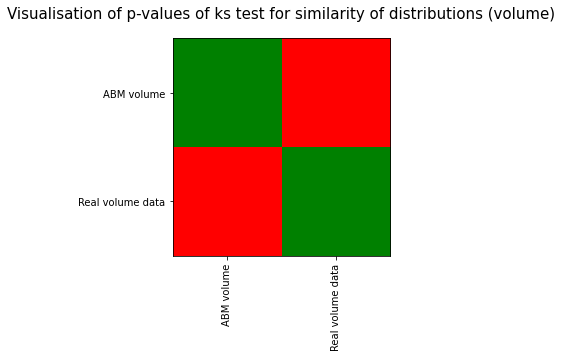

In [106]:
color_matrix = np.where(array_for_ks_test_results_volume < 0.05, 0,1)
cmap = (mpl.colors.ListedColormap(['red', 'green']))
plt.imshow(color_matrix, cmap=cmap, vmin=0, vmax=1)
plt.xticks([0,1], ['ABM volume', 'Real volume data'], rotation = 90)
plt.yticks([0,1], ['ABM volume', 'Real volume data'])
plt.title("Visualisation of p-values of ks test for similarity of distributions (volume)", fontsize=15, pad=20)
plt.show()

Conclusion:

Given this sample and significance level of alpha 0.05, the null hypothesis that the two distributions are identical is rejected for real vs. ABM simulated volume data, and not rejected for real vs. real and ABM simulated vs. ABM simulated volume data

# Long term memory: ACF plots of absolute and squared returns of empirical data vs. simulation

In [107]:
df_closing_SnP500_39_years_clean = pd.read_csv('data/df_closing_SnP500_39_years_clean.csv', parse_dates = True, index_col = 'Date')

In [108]:
df_closing_SnP500_39_years_clean

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,Date.1
Date,,,,,,,,,,,,,,,,,,,,,
1984-01-02,44.00,24.60,41.70,25.625,35.00,23.625,46.000,21.25,15.17,13.75,...,13.01,36.750,36.625,8.75,24.25,29.125,29.76,18.25,35.00,1984-01-02
1984-01-03,44.00,24.60,41.70,25.625,35.00,23.625,46.000,21.25,15.17,13.75,...,13.01,36.750,36.625,8.75,24.25,29.125,29.76,18.25,35.00,1984-01-03
1984-01-04,44.00,24.60,41.70,27.875,35.00,23.625,47.500,21.25,15.17,13.75,...,13.01,37.000,37.125,8.75,24.25,29.125,29.76,18.25,35.00,1984-01-04
1984-01-05,44.00,24.60,41.70,28.250,35.00,23.625,48.000,21.25,15.17,13.75,...,13.01,37.250,37.375,8.75,24.25,29.125,29.76,18.25,35.00,1984-01-05
1984-01-06,44.00,24.60,41.70,27.750,35.00,23.625,47.875,21.25,15.17,13.75,...,13.01,37.625,37.375,8.75,24.25,29.125,29.76,18.25,35.00,1984-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,149.23,12.71,143.28,131.860,163.10,170.010,108.180,63.38,266.09,338.45,...,80.72,70.930,108.680,31.83,109.73,128.900,126.69,248.22,48.45,2022-12-23
2022-12-27,149.55,12.53,145.02,130.030,162.99,169.000,108.570,63.62,265.31,335.09,...,84.33,71.570,110.190,32.07,110.72,129.900,127.28,251.00,48.84,2022-12-27
2022-12-28,148.09,12.32,145.30,126.040,162.23,167.360,107.830,62.60,263.12,328.33,...,80.09,70.570,108.380,30.98,108.94,129.310,125.99,246.84,47.97,2022-12-28


In [109]:
df_closing_DOW_39_years_clean = pd.read_csv('data/df_closing_DOW_39_years_clean.csv', parse_dates = True, index_col = 'Date')


In [110]:
df_closing_DOW_39_years_clean

,UNH,GS,HD,AMGN,MCD,CAT,MSFT,V,HON,BA,...,NKE,MRK,DIS,KO,DOW,CSCO,VZ,WBA,INTC,Date.1
Date,,,,,,,,,,,,,,,,,,,,,
1984-01-02,4.688,70.375,25.25,7.250,69.625,45.875,28.00,56.50,55.625,44.000,...,14.875,90.375,52.625,53.250,49.80,22.25,67.125,37.750,40.750,1984-01-02
1984-01-03,4.688,70.375,25.25,7.250,69.625,45.875,28.00,56.50,55.625,44.000,...,14.875,90.375,52.625,53.250,49.80,22.25,67.125,37.750,40.750,1984-01-03
1984-01-04,4.688,70.375,24.50,7.125,70.875,48.750,28.00,56.50,55.125,45.875,...,15.375,90.250,53.000,54.875,49.80,22.25,69.125,37.625,41.125,1984-01-04
1984-01-05,4.688,70.375,26.00,7.500,72.250,49.000,28.00,56.50,55.625,47.750,...,15.875,91.500,53.250,55.250,49.80,22.25,69.750,37.750,43.000,1984-01-05
1984-01-06,4.688,70.375,25.75,8.000,72.250,48.625,28.00,56.50,54.500,47.625,...,16.375,91.125,52.750,54.625,49.80,22.25,71.000,37.875,42.750,1984-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,531.310,345.510,318.73,263.920,267.570,239.870,238.73,205.83,213.870,189.060,...,116.250,111.860,88.010,63.820,50.86,47.48,38.410,38.630,26.090,2022-12-23
2022-12-27,531.990,341.970,319.55,263.390,266.840,243.140,236.96,206.29,214.890,189.400,...,117.560,112.120,86.370,64.210,51.19,47.53,39.250,38.310,25.940,2022-12-27
2022-12-28,528.450,340.870,315.73,261.420,265.110,239.380,234.53,204.99,212.190,188.380,...,114.980,111.080,84.170,63.570,49.99,47.07,38.810,37.580,25.540,2022-12-28


In [111]:
df_closing_DOW_39_years_clean

,UNH,GS,HD,AMGN,MCD,CAT,MSFT,V,HON,BA,...,NKE,MRK,DIS,KO,DOW,CSCO,VZ,WBA,INTC,Date.1
Date,,,,,,,,,,,,,,,,,,,,,
1984-01-02,4.688,70.375,25.25,7.250,69.625,45.875,28.00,56.50,55.625,44.000,...,14.875,90.375,52.625,53.250,49.80,22.25,67.125,37.750,40.750,1984-01-02
1984-01-03,4.688,70.375,25.25,7.250,69.625,45.875,28.00,56.50,55.625,44.000,...,14.875,90.375,52.625,53.250,49.80,22.25,67.125,37.750,40.750,1984-01-03
1984-01-04,4.688,70.375,24.50,7.125,70.875,48.750,28.00,56.50,55.125,45.875,...,15.375,90.250,53.000,54.875,49.80,22.25,69.125,37.625,41.125,1984-01-04
1984-01-05,4.688,70.375,26.00,7.500,72.250,49.000,28.00,56.50,55.625,47.750,...,15.875,91.500,53.250,55.250,49.80,22.25,69.750,37.750,43.000,1984-01-05
1984-01-06,4.688,70.375,25.75,8.000,72.250,48.625,28.00,56.50,54.500,47.625,...,16.375,91.125,52.750,54.625,49.80,22.25,71.000,37.875,42.750,1984-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,531.310,345.510,318.73,263.920,267.570,239.870,238.73,205.83,213.870,189.060,...,116.250,111.860,88.010,63.820,50.86,47.48,38.410,38.630,26.090,2022-12-23
2022-12-27,531.990,341.970,319.55,263.390,266.840,243.140,236.96,206.29,214.890,189.400,...,117.560,112.120,86.370,64.210,51.19,47.53,39.250,38.310,25.940,2022-12-27
2022-12-28,528.450,340.870,315.73,261.420,265.110,239.380,234.53,204.99,212.190,188.380,...,114.980,111.080,84.170,63.570,49.99,47.07,38.810,37.580,25.540,2022-12-28


In [112]:
returns = df_closing_DOW_39_years_clean.drop(columns = 'Date.1').pct_change().dropna()
abs_returns = returns.abs()
squared_returns = returns

In [113]:
abs_returns

,UNH,GS,HD,AMGN,MCD,CAT,MSFT,V,HON,BA,...,MMM,NKE,MRK,DIS,KO,DOW,CSCO,VZ,WBA,INTC
Date,,,,,,,,,,,,,,,,,,,,,
1984-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1984-01-04,0.000000,0.000000,0.029703,0.017241,0.017953,0.062670,0.000000,0.000000,0.008989,0.042614,...,0.022796,0.033613,0.001383,0.007126,0.030516,0.000000,0.000000,0.029795,0.003311,0.009202
1984-01-05,0.000000,0.000000,0.061224,0.052632,0.019400,0.005128,0.000000,0.000000,0.009070,0.040872,...,0.008915,0.032520,0.013850,0.004717,0.006834,0.000000,0.000000,0.009042,0.003322,0.045593
1984-01-06,0.000000,0.000000,0.009615,0.066667,0.000000,0.007653,0.000000,0.000000,0.020225,0.002618,...,0.002946,0.031496,0.004098,0.009390,0.011312,0.000000,0.000000,0.017921,0.003311,0.005814
1984-01-09,0.000000,0.000000,0.000000,0.015625,0.029412,0.010283,0.000000,0.000000,0.004587,0.002625,...,0.008863,0.007634,0.010974,0.000000,0.013730,0.000000,0.000000,0.012324,0.023102,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.008006,0.000203,0.008256,0.005052,0.006773,0.009809,0.002267,0.003755,0.007348,0.004303,...,0.011925,0.003941,0.005574,0.015461,0.007578,0.013753,0.003381,0.002610,0.004943,0.004621
2022-12-27,0.001280,0.010246,0.002573,0.002008,0.002728,0.013632,0.007414,0.002235,0.004769,0.001798,...,0.000666,0.011269,0.002324,0.018634,0.006111,0.006488,0.001053,0.021869,0.008284,0.005749
2022-12-28,0.006654,0.003217,0.011954,0.007479,0.006483,0.015464,0.010255,0.006302,0.012565,0.005385,...,0.016054,0.021946,0.009276,0.025472,0.009967,0.023442,0.009678,0.011210,0.019055,0.015420


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after t

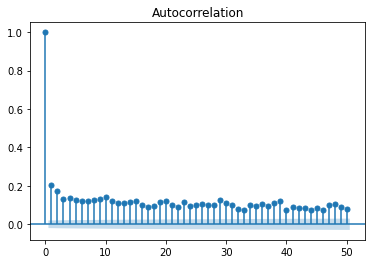

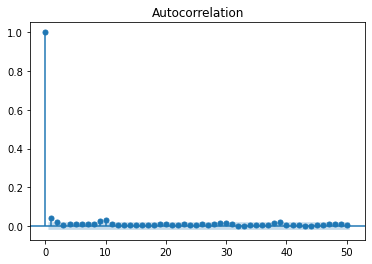

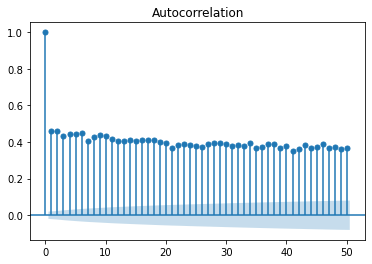

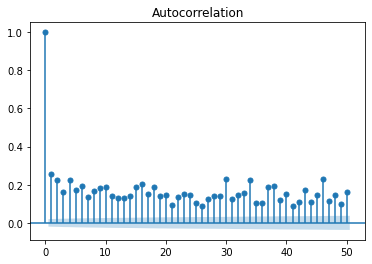

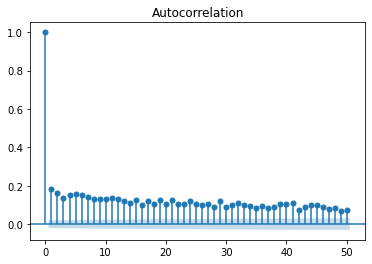

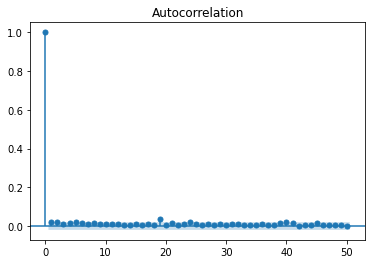

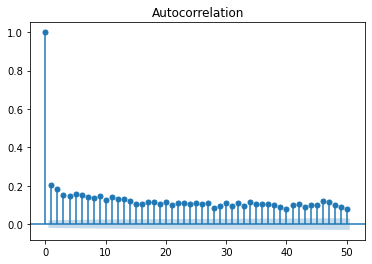

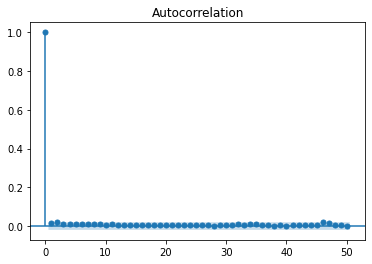

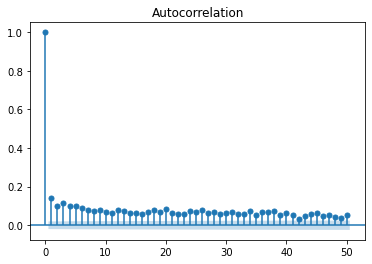

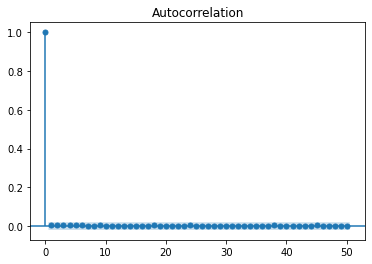

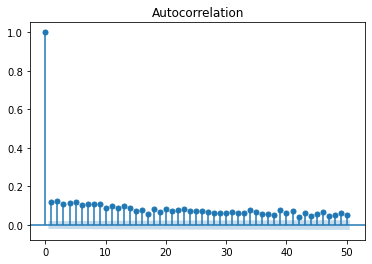

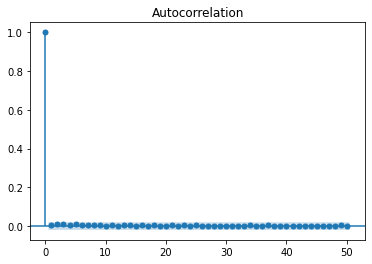

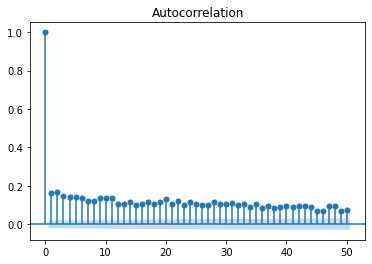

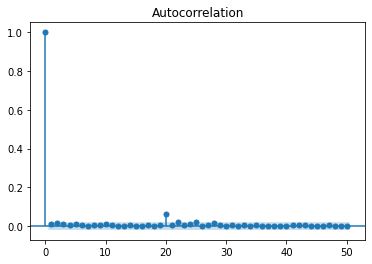

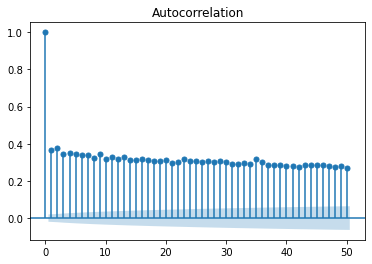

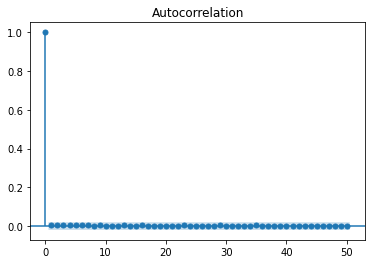

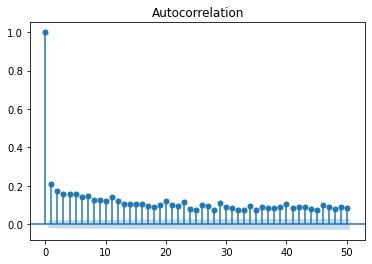

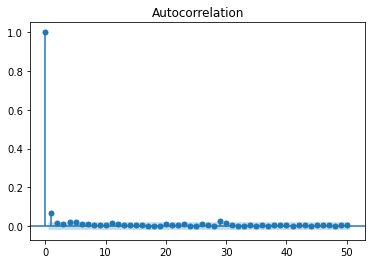

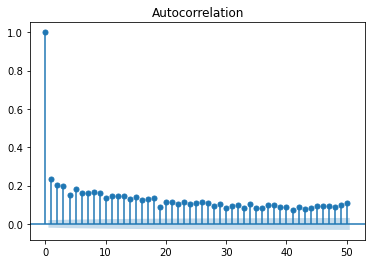

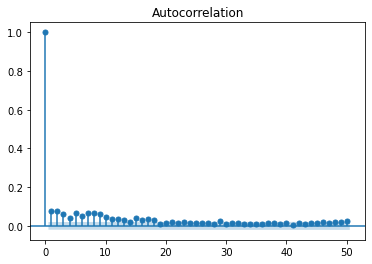

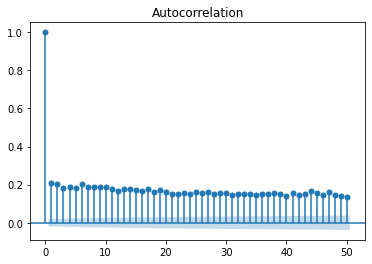

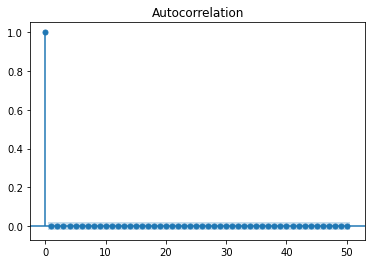

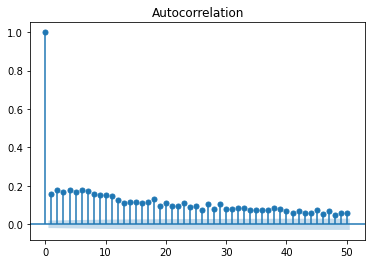

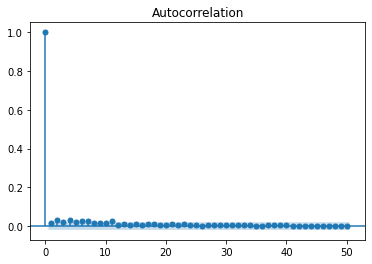

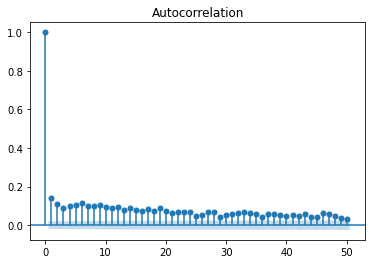

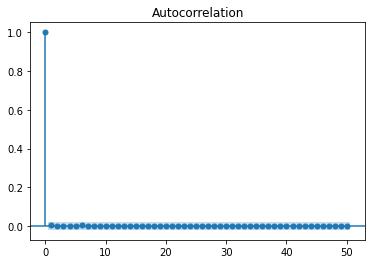

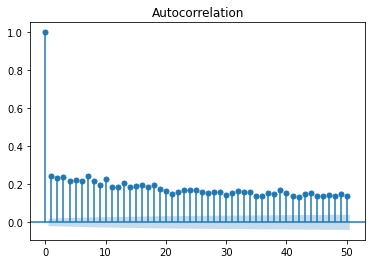

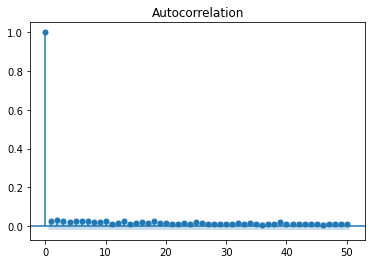

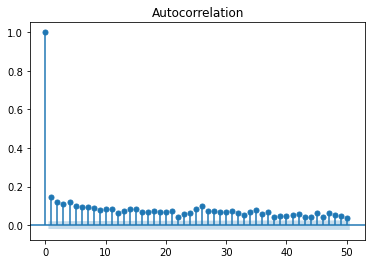

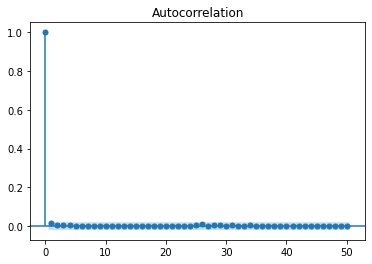

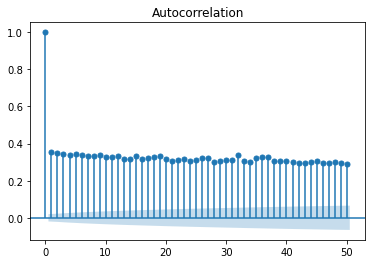

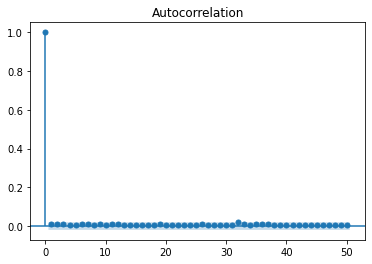

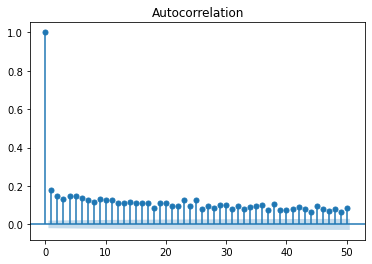

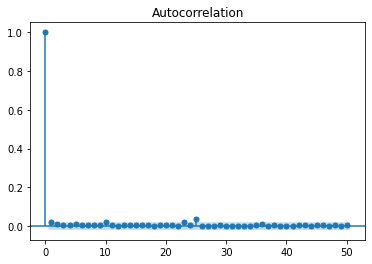

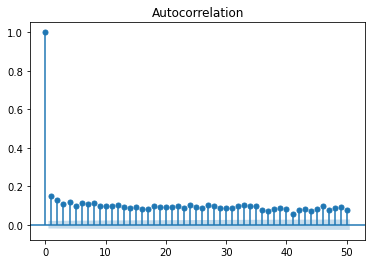

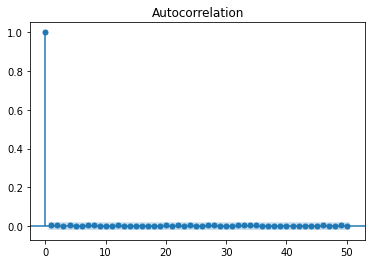

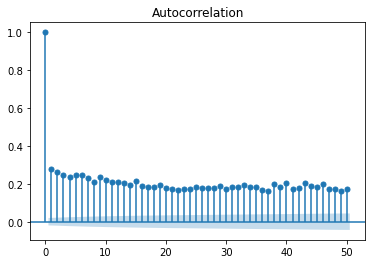

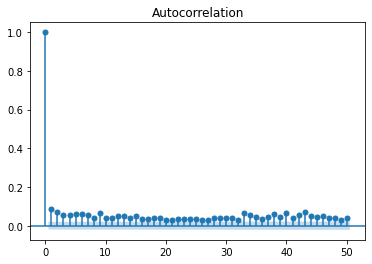

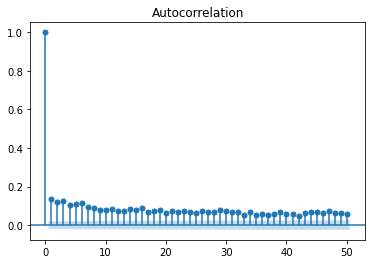

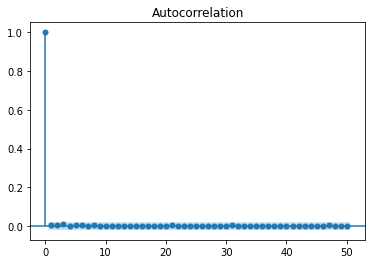

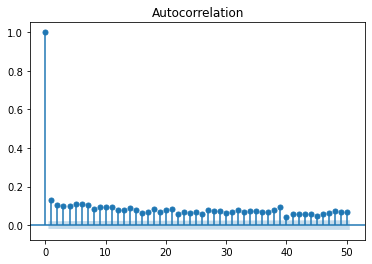

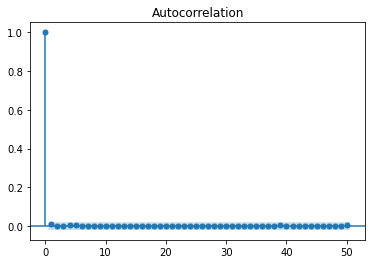

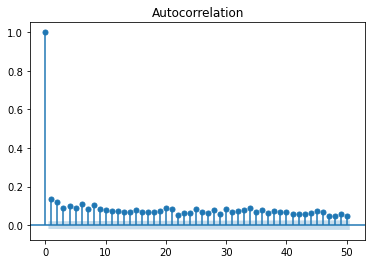

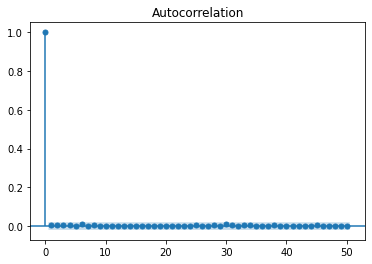

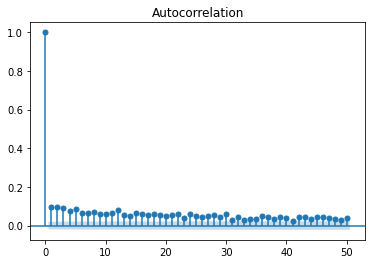

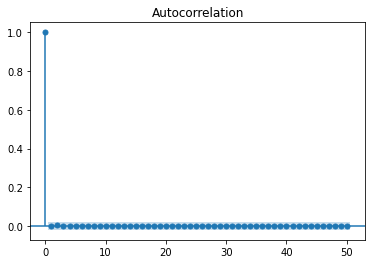

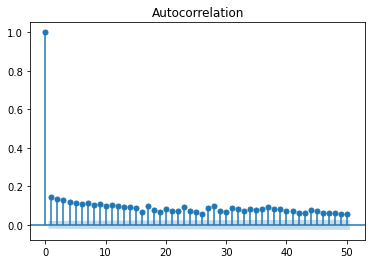

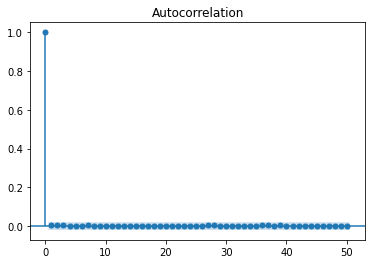

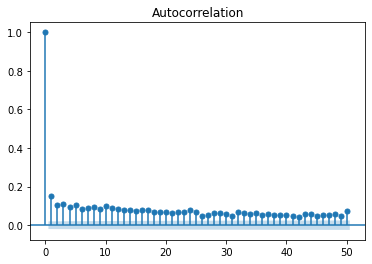

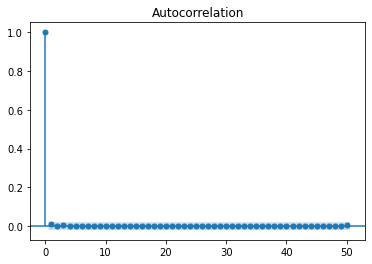

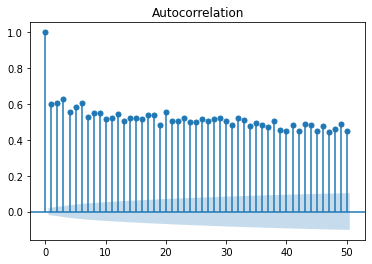

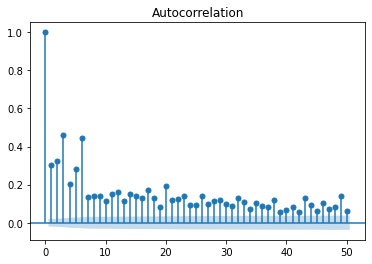

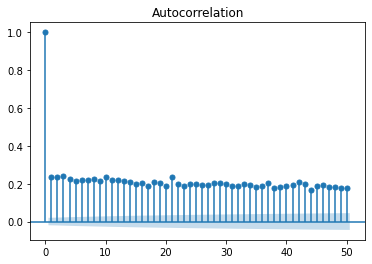

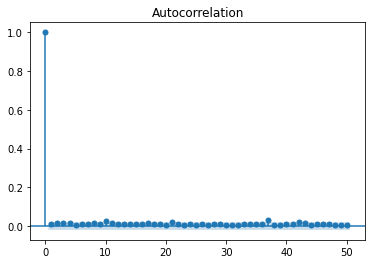

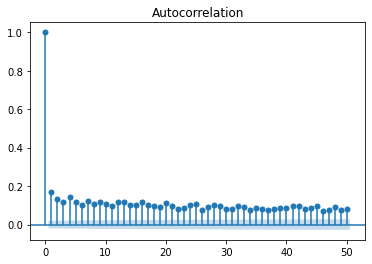

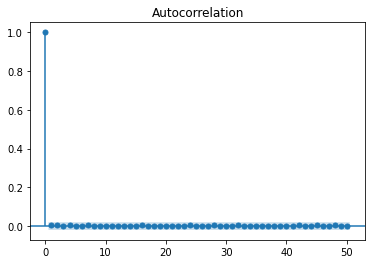

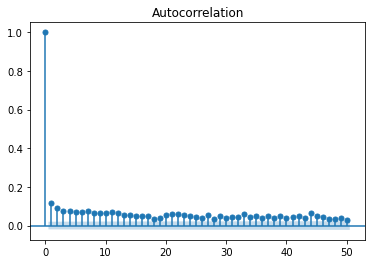

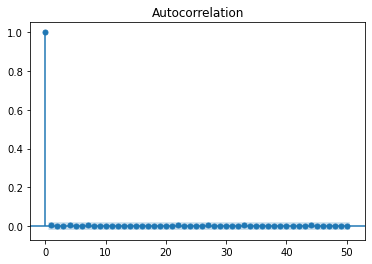

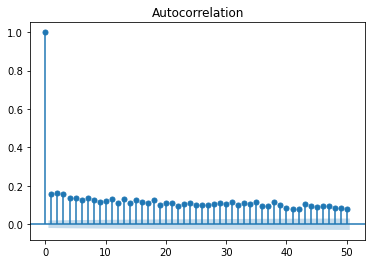

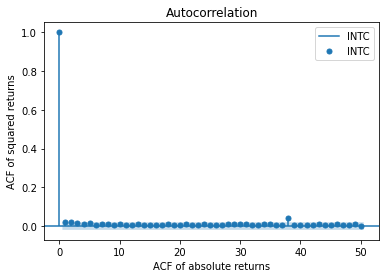

In [114]:
# Plot the ACF v0.1
lags = 50
acf_abs_returns_per_stock = []
acf_squared_returns_per_stock = []
acf_abs_returns_per_stock_log = []
acf_squared_returns_per_stock_log = []
for stock in returns.columns:
    abs_returns = returns[stock].abs()
    squared_returns = np.square(returns[stock])
    plot_acf(abs_returns, lags = lags, label = stock)
    plot_acf(squared_returns, lags = lags, label = stock)
    acf_abs_returns = acf(abs_returns, nlags = lags)
    acf_squared_returns = acf(squared_returns, nlags = lags)
    acf_abs_returns_log = np.log(acf_abs_returns)
    acf_squared_returns_log = np.log(acf_squared_returns)
    # plt.scatter(acf_abs_returns_log, acf_squared_returns_log, label = stock)
    acf_abs_returns_per_stock.append(acf_abs_returns)
    acf_squared_returns_per_stock.append(acf_squared_returns)
    acf_abs_returns_per_stock_log.append(acf_abs_returns_log)
    acf_squared_returns_per_stock_log.append(acf_squared_returns_log)
plt.legend()
plt.ylabel('ACF of squared returns')
plt.xlabel('ACF of absolute returns')
plt.show()

In [115]:
y = acf_abs_returns_per_stock_log

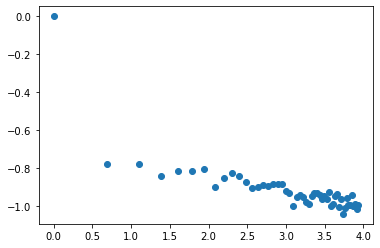

In [116]:
# y = y[~np.isnan(y)]
y = y[y != 0]

plt.scatter(np.log(range(1,len(y)+1)), y)
exponent = np.polyfit(np.log(range(1,len(y)+1)), y, 1)

C:\Users\iChin\AppData\Local\Temp/ipykernel_30300/1625601819.py:6: RuntimeWarning:

divide by zero encountered in log

C:\Users\iChin\AppData\Local\Temp/ipykernel_30300/1625601819.py:7: RuntimeWarning:

divide by zero encountered in log



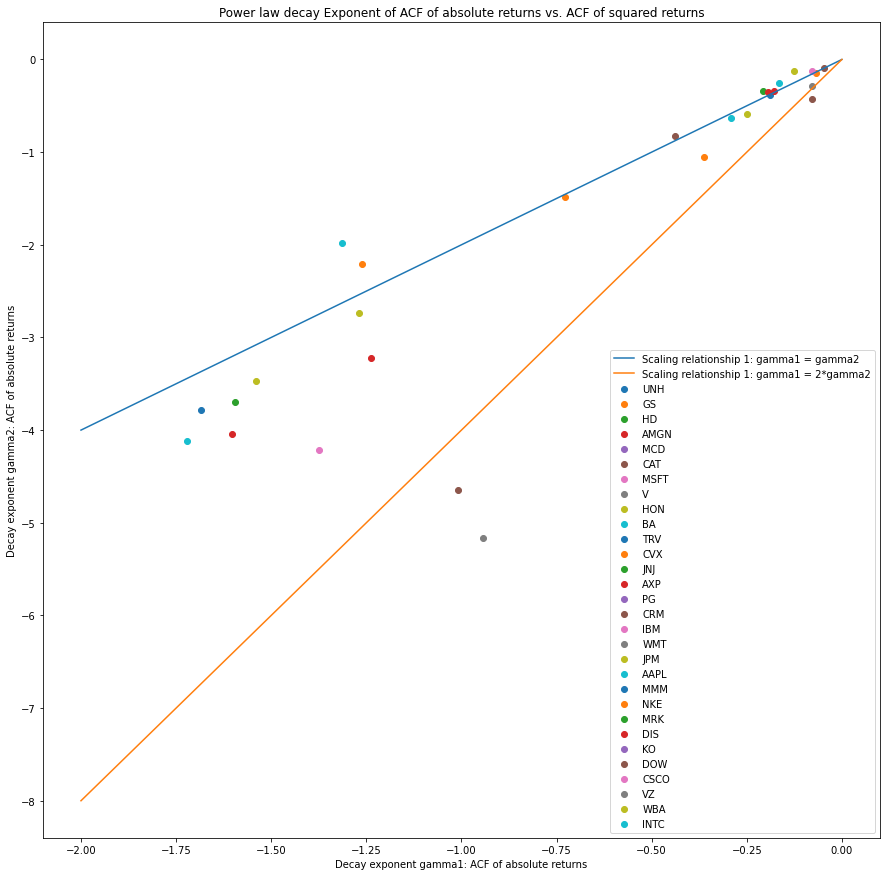

In [117]:
plt.figure(figsize=(15,15))
for index in range(len(acf_abs_returns_per_stock_log)):
    # exponent_acf_abs_returns = np.polyfit(range(len(acf_abs_returns_per_stock_log[index]), acf_abs_returns_per_stock_log[index],1))
    # exponent_acf_squared_returns = np.polyfit(range(len(acf_squared_returns_per_stock_log[index]), acf_squared_returns_per_stock_log[index],1))

    exponent_acf_abs_returns = np.polyfit(np.log(range(len(acf_abs_returns_per_stock_log[index])))[1:-1], acf_abs_returns_per_stock_log[index][1:-1],1)
    exponent_acf_squared_returns = np.polyfit(np.log(range(len(acf_squared_returns_per_stock_log[index])))[1:-1], acf_squared_returns_per_stock_log[index][1:-1],1)
    plt.scatter(exponent_acf_abs_returns,exponent_acf_squared_returns, label = returns.columns[index])
    # scaling relationhip 1: gamma1 = gamma2
    gamma1 = np.linspace(-2, 0, 100)
    gamma2 = gamma1
    # scaling relationhip 2: gamma1 = 2*gamma2
    gamma1 = np.linspace(-2, 0, 100)
    gamma2 = gamma1*2
plt.plot(gamma1, gamma2, label = 'Scaling relationship 1: gamma1 = gamma2')
plt.plot(gamma1, 2*gamma2, label = 'Scaling relationship 1: gamma1 = 2*gamma2')
plt.legend()
plt.xlabel('Decay exponent gamma1: ACF of absolute returns')
plt.ylabel('Decay exponent gamma2: ACF of absolute returns')
plt.title('Power law decay Exponent of ACF of absolute returns vs. ACF of squared returns')
plt.show()

Feng et al's (2012) found scaling relationships (derived in appendix 3 of the paper) between power law decay exponents largely hold on a current dataset with CAT, V and AAPL being the outliers.

# Comparing S&P 500 total index closing ACF 

Since the complete 40 year data of S&P index closing prices was not avaiable, we take the last 10 years. The goal is to find out if the long term memory (ACF decay) is similair in both the empirical and simulated model data.

# Long term memory: ACF plots of absolute and squared returns of empirical data vs. simulation

In [118]:
df_closing_SnP500_39_years_clean = pd.read_csv('data/df_closing_SnP500_39_years_clean.csv', parse_dates = True, index_col = 'Date')

In [119]:
df_closing_SnP500_39_years_clean

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,Date.1
Date,,,,,,,,,,,,,,,,,,,,,
1984-01-02,44.00,24.60,41.70,25.625,35.00,23.625,46.000,21.25,15.17,13.75,...,13.01,36.750,36.625,8.75,24.25,29.125,29.76,18.25,35.00,1984-01-02
1984-01-03,44.00,24.60,41.70,25.625,35.00,23.625,46.000,21.25,15.17,13.75,...,13.01,36.750,36.625,8.75,24.25,29.125,29.76,18.25,35.00,1984-01-03
1984-01-04,44.00,24.60,41.70,27.875,35.00,23.625,47.500,21.25,15.17,13.75,...,13.01,37.000,37.125,8.75,24.25,29.125,29.76,18.25,35.00,1984-01-04
1984-01-05,44.00,24.60,41.70,28.250,35.00,23.625,48.000,21.25,15.17,13.75,...,13.01,37.250,37.375,8.75,24.25,29.125,29.76,18.25,35.00,1984-01-05
1984-01-06,44.00,24.60,41.70,27.750,35.00,23.625,47.875,21.25,15.17,13.75,...,13.01,37.625,37.375,8.75,24.25,29.125,29.76,18.25,35.00,1984-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,149.23,12.71,143.28,131.860,163.10,170.010,108.180,63.38,266.09,338.45,...,80.72,70.930,108.680,31.83,109.73,128.900,126.69,248.22,48.45,2022-12-23
2022-12-27,149.55,12.53,145.02,130.030,162.99,169.000,108.570,63.62,265.31,335.09,...,84.33,71.570,110.190,32.07,110.72,129.900,127.28,251.00,48.84,2022-12-27
2022-12-28,148.09,12.32,145.30,126.040,162.23,167.360,107.830,62.60,263.12,328.33,...,80.09,70.570,108.380,30.98,108.94,129.310,125.99,246.84,47.97,2022-12-28


In [120]:
df_closing_DOW_39_years_clean = pd.read_csv('data/df_closing_DOW_39_years_clean.csv', parse_dates = True, index_col = 'Date')


In [121]:
df_closing_DOW_39_years_clean

,UNH,GS,HD,AMGN,MCD,CAT,MSFT,V,HON,BA,...,NKE,MRK,DIS,KO,DOW,CSCO,VZ,WBA,INTC,Date.1
Date,,,,,,,,,,,,,,,,,,,,,
1984-01-02,4.688,70.375,25.25,7.250,69.625,45.875,28.00,56.50,55.625,44.000,...,14.875,90.375,52.625,53.250,49.80,22.25,67.125,37.750,40.750,1984-01-02
1984-01-03,4.688,70.375,25.25,7.250,69.625,45.875,28.00,56.50,55.625,44.000,...,14.875,90.375,52.625,53.250,49.80,22.25,67.125,37.750,40.750,1984-01-03
1984-01-04,4.688,70.375,24.50,7.125,70.875,48.750,28.00,56.50,55.125,45.875,...,15.375,90.250,53.000,54.875,49.80,22.25,69.125,37.625,41.125,1984-01-04
1984-01-05,4.688,70.375,26.00,7.500,72.250,49.000,28.00,56.50,55.625,47.750,...,15.875,91.500,53.250,55.250,49.80,22.25,69.750,37.750,43.000,1984-01-05
1984-01-06,4.688,70.375,25.75,8.000,72.250,48.625,28.00,56.50,54.500,47.625,...,16.375,91.125,52.750,54.625,49.80,22.25,71.000,37.875,42.750,1984-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,531.310,345.510,318.73,263.920,267.570,239.870,238.73,205.83,213.870,189.060,...,116.250,111.860,88.010,63.820,50.86,47.48,38.410,38.630,26.090,2022-12-23
2022-12-27,531.990,341.970,319.55,263.390,266.840,243.140,236.96,206.29,214.890,189.400,...,117.560,112.120,86.370,64.210,51.19,47.53,39.250,38.310,25.940,2022-12-27
2022-12-28,528.450,340.870,315.73,261.420,265.110,239.380,234.53,204.99,212.190,188.380,...,114.980,111.080,84.170,63.570,49.99,47.07,38.810,37.580,25.540,2022-12-28


In [122]:
df_closing_DOW_39_years_clean.columns

Index(['UNH', 'GS', 'HD', 'AMGN', 'MCD', 'CAT', 'MSFT', 'V', 'HON', 'BA',
       'TRV', 'CVX', 'JNJ', 'AXP', 'PG', 'CRM', 'IBM', 'WMT', 'JPM', 'AAPL',
       'MMM', 'NKE', 'MRK', 'DIS', 'KO', 'DOW', 'CSCO', 'VZ', 'WBA', 'INTC',
       'Date.1'],
      dtype='object')

In [123]:
returns = df_closing_DOW_39_years_clean.drop(columns = 'Date.1').pct_change().dropna()
abs_returns = returns.abs()
squared_returns = returns

In [124]:
abs_returns

,UNH,GS,HD,AMGN,MCD,CAT,MSFT,V,HON,BA,...,MMM,NKE,MRK,DIS,KO,DOW,CSCO,VZ,WBA,INTC
Date,,,,,,,,,,,,,,,,,,,,,
1984-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1984-01-04,0.000000,0.000000,0.029703,0.017241,0.017953,0.062670,0.000000,0.000000,0.008989,0.042614,...,0.022796,0.033613,0.001383,0.007126,0.030516,0.000000,0.000000,0.029795,0.003311,0.009202
1984-01-05,0.000000,0.000000,0.061224,0.052632,0.019400,0.005128,0.000000,0.000000,0.009070,0.040872,...,0.008915,0.032520,0.013850,0.004717,0.006834,0.000000,0.000000,0.009042,0.003322,0.045593
1984-01-06,0.000000,0.000000,0.009615,0.066667,0.000000,0.007653,0.000000,0.000000,0.020225,0.002618,...,0.002946,0.031496,0.004098,0.009390,0.011312,0.000000,0.000000,0.017921,0.003311,0.005814
1984-01-09,0.000000,0.000000,0.000000,0.015625,0.029412,0.010283,0.000000,0.000000,0.004587,0.002625,...,0.008863,0.007634,0.010974,0.000000,0.013730,0.000000,0.000000,0.012324,0.023102,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.008006,0.000203,0.008256,0.005052,0.006773,0.009809,0.002267,0.003755,0.007348,0.004303,...,0.011925,0.003941,0.005574,0.015461,0.007578,0.013753,0.003381,0.002610,0.004943,0.004621
2022-12-27,0.001280,0.010246,0.002573,0.002008,0.002728,0.013632,0.007414,0.002235,0.004769,0.001798,...,0.000666,0.011269,0.002324,0.018634,0.006111,0.006488,0.001053,0.021869,0.008284,0.005749
2022-12-28,0.006654,0.003217,0.011954,0.007479,0.006483,0.015464,0.010255,0.006302,0.012565,0.005385,...,0.016054,0.021946,0.009276,0.025472,0.009967,0.023442,0.009678,0.011210,0.019055,0.015420


### Here we show the ACF plots of 30 DOW jones stocks, to get a feeling for how the autocorrelation function looks

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after t

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



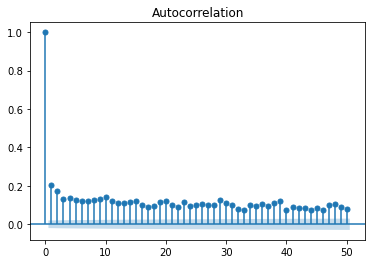

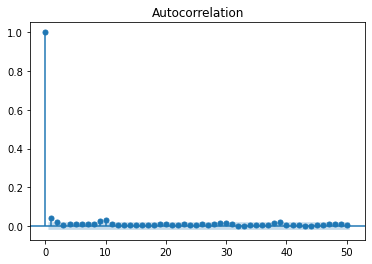

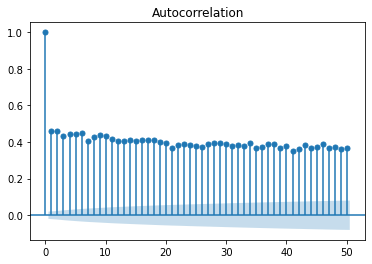

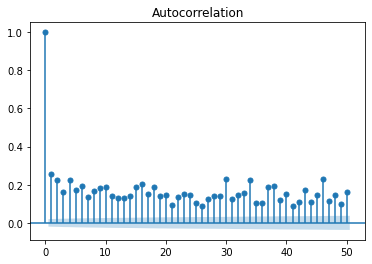

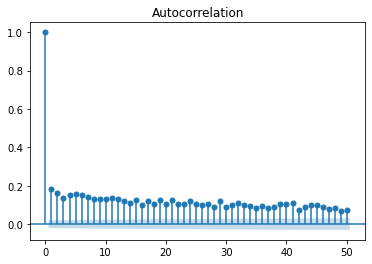

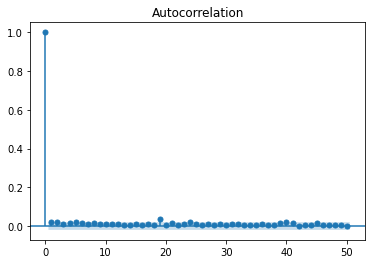

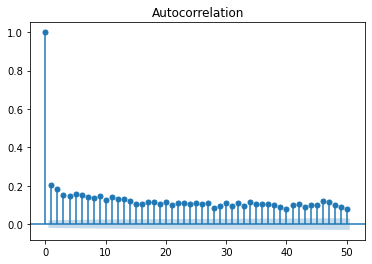

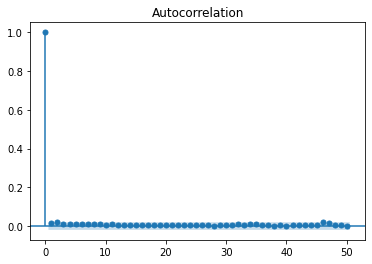

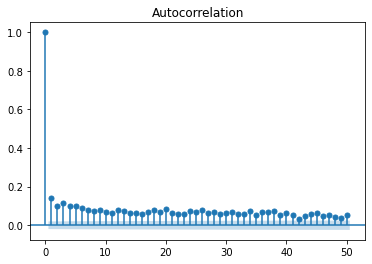

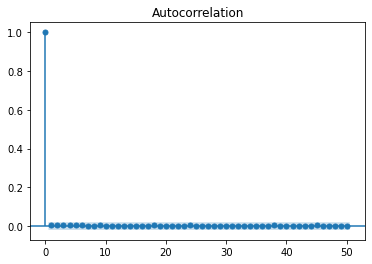

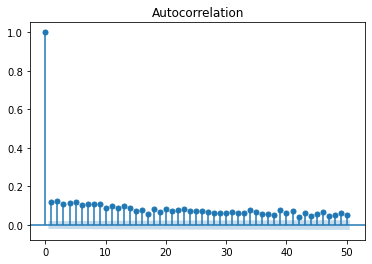

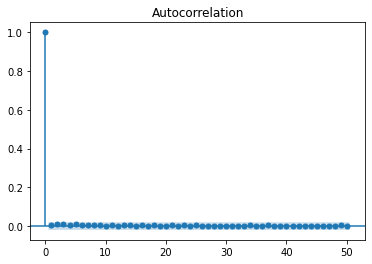

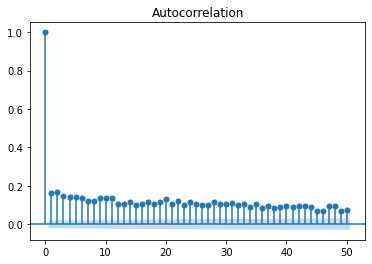

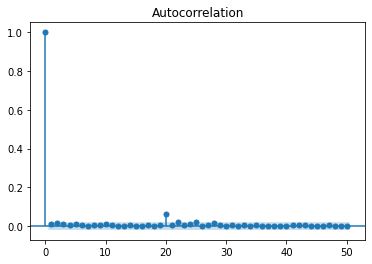

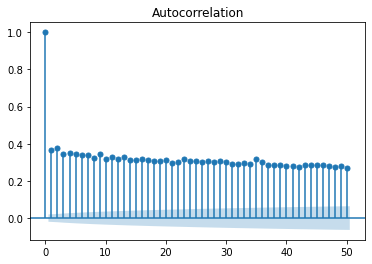

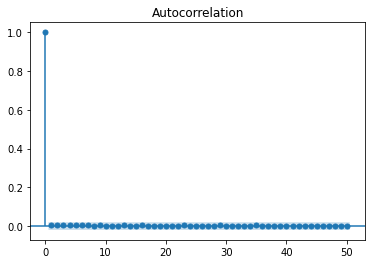

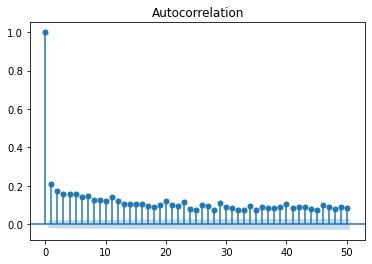

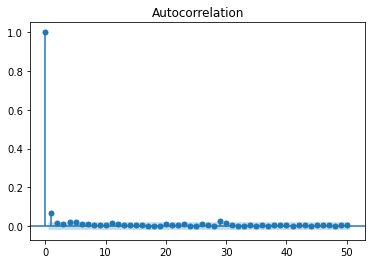

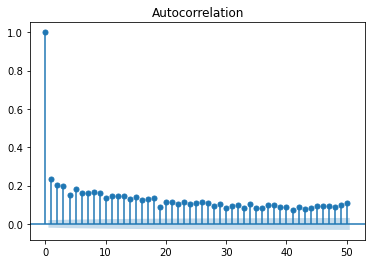

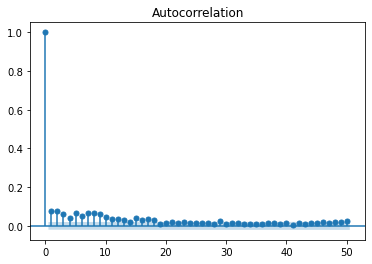

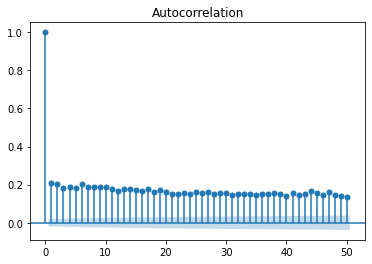

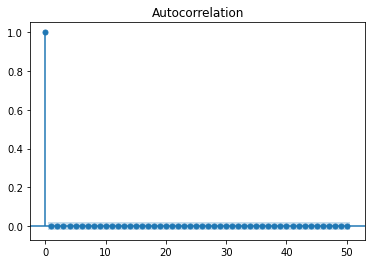

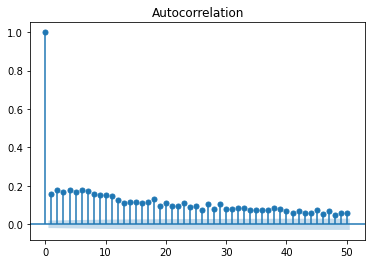

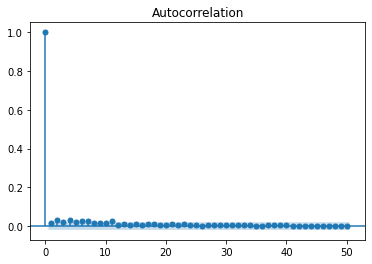

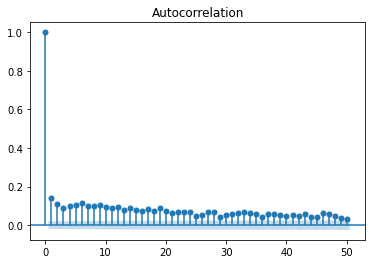

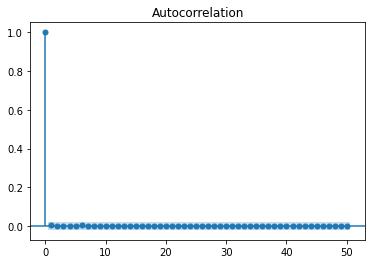

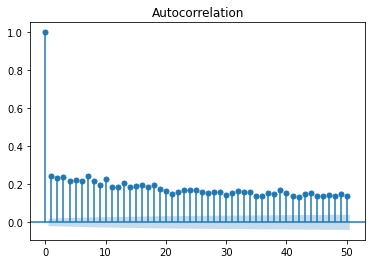

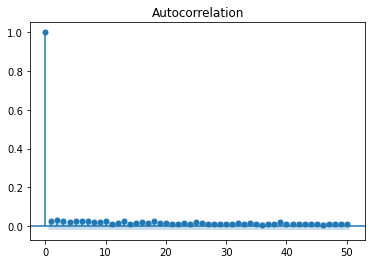

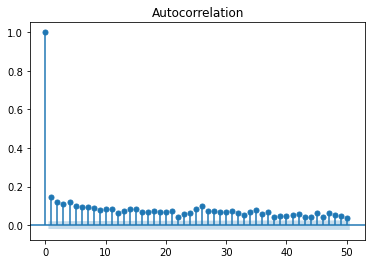

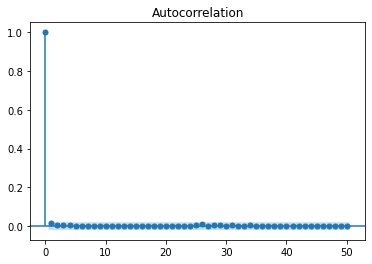

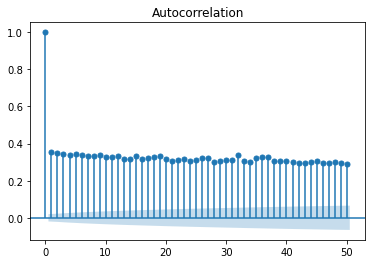

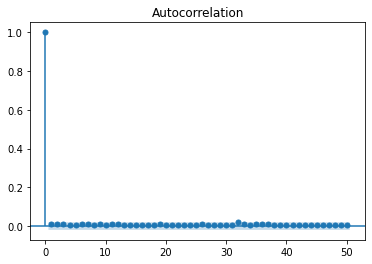

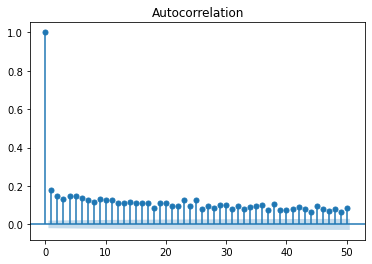

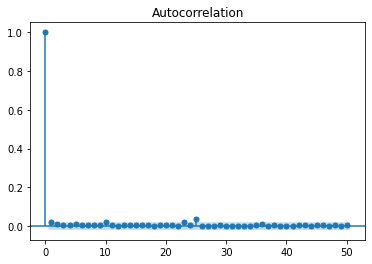

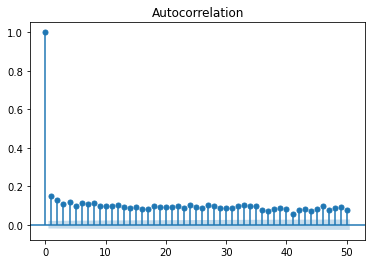

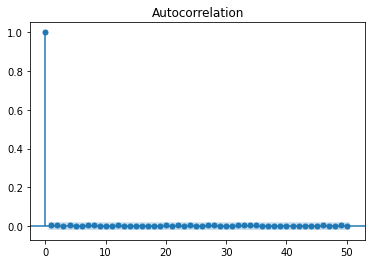

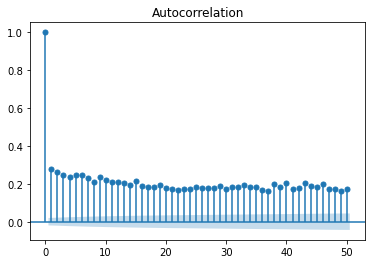

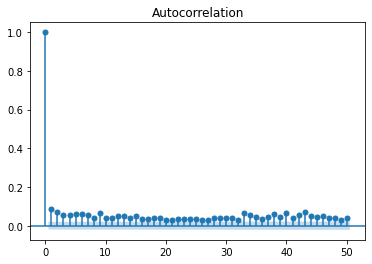

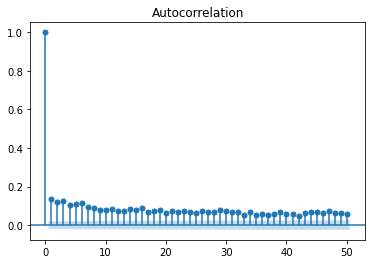

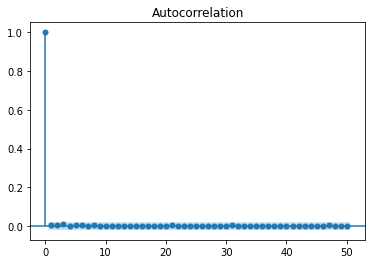

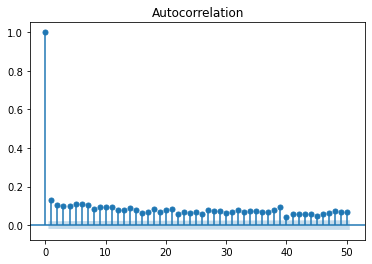

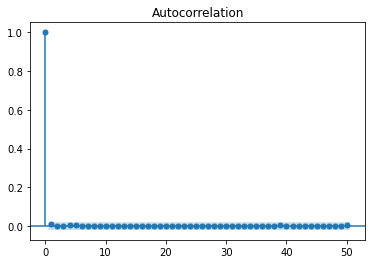

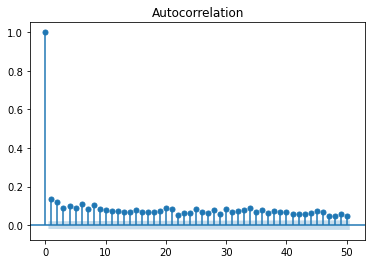

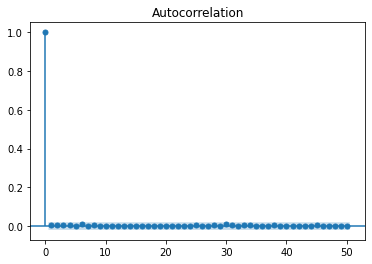

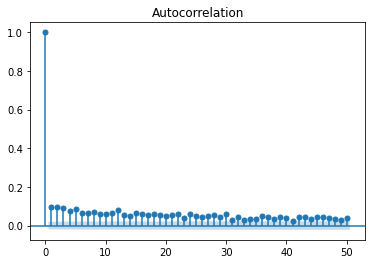

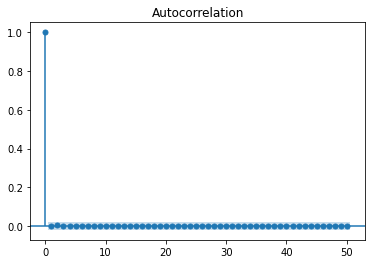

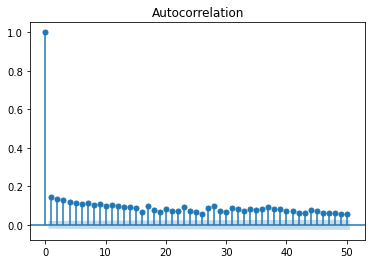

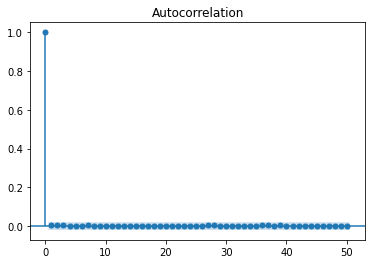

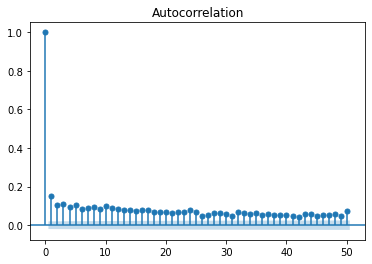

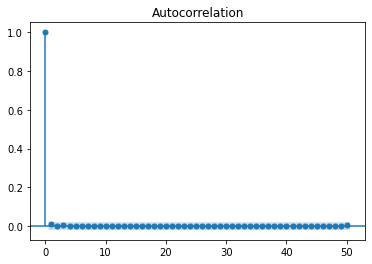

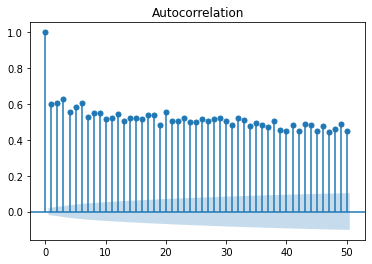

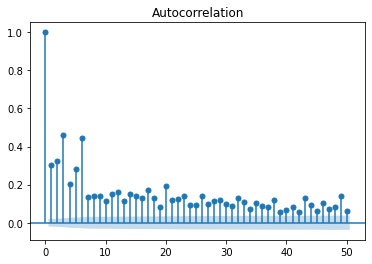

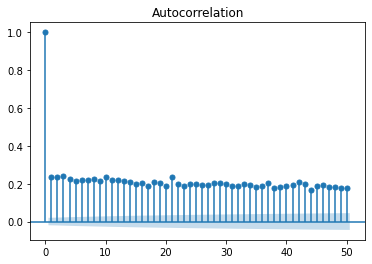

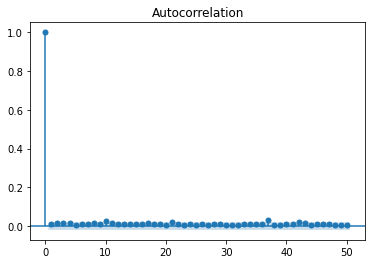

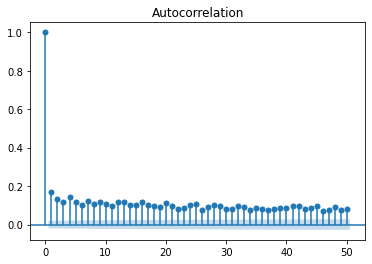

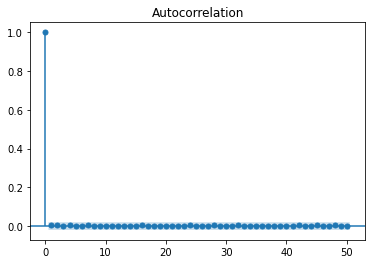

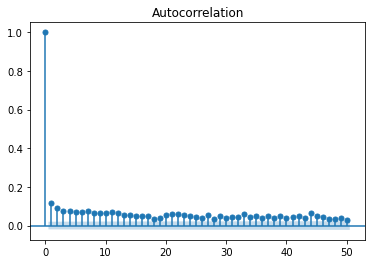

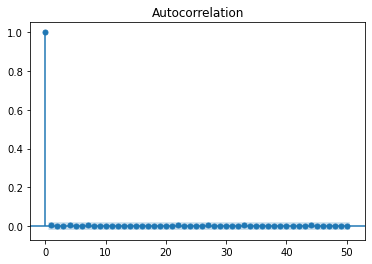

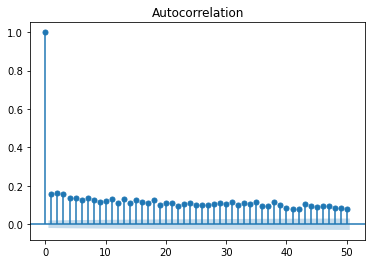

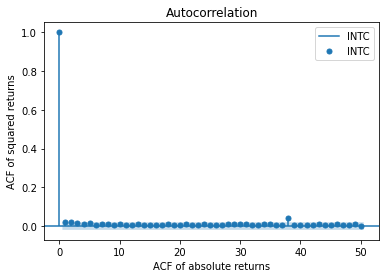

In [125]:
# Plot the ACF v0.1
lags = 50
acf_abs_returns_per_stock = []
acf_squared_returns_per_stock = []
acf_abs_returns_per_stock_log = []
acf_squared_returns_per_stock_log = []
for stock in returns.columns:
    abs_returns = returns[stock].abs()
    squared_returns = np.square(returns[stock])
    plot_acf(abs_returns, lags = lags, label = stock)
    plot_acf(squared_returns, lags = lags, label = stock)
    acf_abs_returns = acf(abs_returns, nlags = lags)
    acf_squared_returns = acf(squared_returns, nlags = lags)
    acf_abs_returns_log = np.log(acf_abs_returns)
    acf_squared_returns_log = np.log(acf_squared_returns)
    acf_abs_returns_per_stock.append(acf_abs_returns)
    acf_squared_returns_per_stock.append(acf_squared_returns)
    acf_abs_returns_per_stock_log.append(acf_abs_returns_log)
    acf_squared_returns_per_stock_log.append(acf_squared_returns_log)
plt.legend()
plt.ylabel('ACF of squared returns')
plt.xlabel('ACF of absolute returns')
plt.show()

### The next step is to find the powerlaw exponent of the autocorrelation function, you can plot the ACF values on a log log plot and fit a straight line to it. Below we show an example for a single stock:

In [126]:
def plot_log_acf_vs_fitted_line_to_decay_exponent(y):
    '''This function takes a list of y values and plots the log of the y values against the log of the x values,
     where x is a range of numbers from 1 to the length of y (so y is basically the lags of the ACF) 
     It then fits a line to the data and plots the line on top of the data.
    It also prints the slope of the line, which is the decay exponent of the data.'''
    # convert y to a numpy array
    y = np.array(y)
    length_of_y = len(y)
    y = np.array(y)
    # clean the data, removing nans, infs and 0 values so the log transformation works
    y = y[y != 0]
    y = y[~np.isnan(y)]
    y = y[~np.isinf(y)]
    y = y[y != 0]
    # also taking absolute value of y, incase there are negative correlations, otherwise the log transformation wont work
    y = np.abs(y)

    # log transormation
    y = np.log(y)

    # take a range of x values from 1 to the length of y, this representes the lags
    x = np.arange(1, len(y) + 1)
    x = np.log(x)

    # Reshape the arrays to have a single column
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # plot ACF function on a log log scatter plot

    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(0, 8))
    ax.set_yticks(np.arange(-10, 2))
    ax.set_xlim([0, 8])
    ax.set_ylim([-10, 2])
    ax.scatter(x, y, alpha=0.2)
    # Train the linear regression model
    model = LinearRegression()
    model.fit(x, y)
    print("The R-squared value =", model.score(x,y))

    x_input = np.arange(0, 8).reshape(-1, 1)
    # Plot the data vs the model prediction
    y_fitted = model.predict(x_input)
    ax.set_title('Line Fitted to Decay of ACF')
    ax.set_xlabel('log(lag)')
    ax.set_ylabel('log(ACF)')

    ax.plot(x_input, y_fitted, color='red')
    print('The powerlaw exponent of the decay of the ACF of is around: ' + str(model.coef_[0][0]))


The R-squared value = 0.632538292910898
The powerlaw exponent of the decay of the ACF of is around: -0.3352442570474084


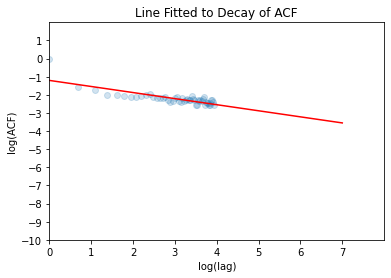

In [127]:
plot_log_acf_vs_fitted_line_to_decay_exponent(acf_abs_returns_per_stock[0])

Using the same logic we create the function below:

In [128]:
def return_powerlaw_exponent_of_ACF_series(data):
    ''' Returns the powerlaw decay exponent of a given ACF series'''
    # convert to numpy array
    y = data
    y = np.array(y)
    # Remove NaN, Inf and 0 values to avoid errors on log
    y = y[y != 0]
    y = y[~np.isnan(y)]
    y = y[~np.isinf(y)]
    y = np.abs(y)
    y = np.log(y)
    # Create the logarithmic x-values
    x = np.arange(1, len(y) + 1)
    x = np.log(x)

    # Reshape the arrays to have a single column
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Train the linear regression model
    model = LinearRegression()
    model.fit(x, y)

    # Return the slope of the regression line
    return model.coef_[0][0]

In [129]:
# Testing the function, we can see the coefficient is indeed the same
return_powerlaw_exponent_of_ACF_series(acf_abs_returns_per_stock[0])

-0.3352442570474084

### Next, using this code, we reproduce figure 3 of Feng et al.'s paper

We do this see if the mathematical scaling relations derived in appendix 2 of the paper hold on this dataset. The reason we do this, is because if these relationships hold, this is evidence that our stochastic model should have the potential for a decent fit in principle

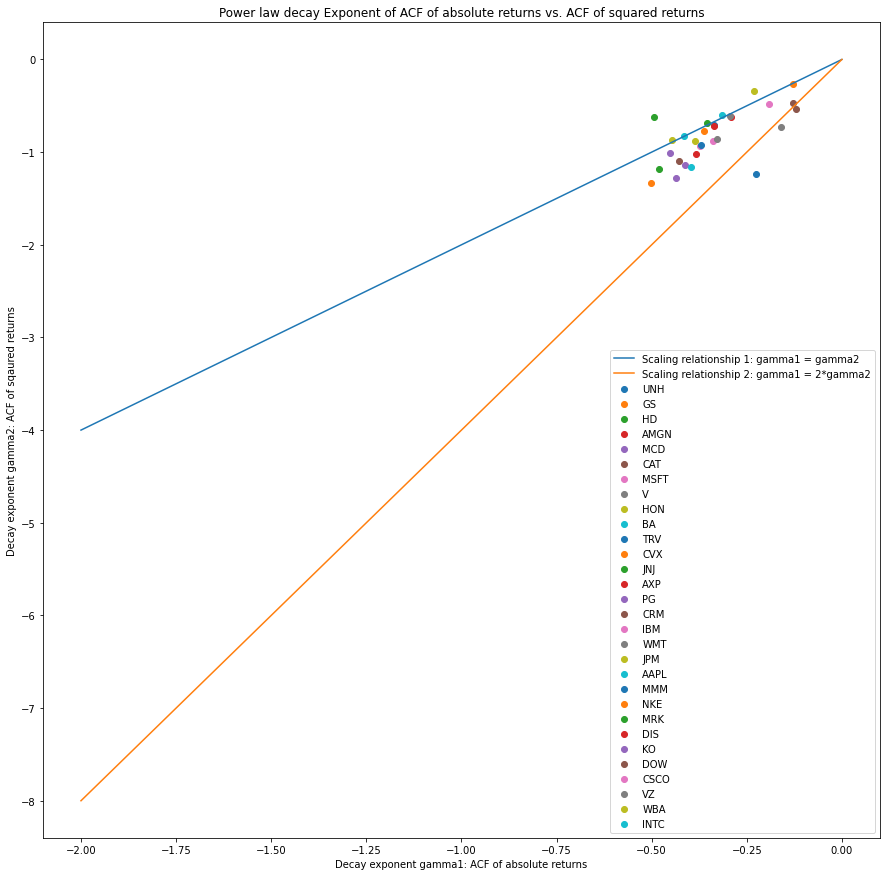

In [130]:
plt.figure(figsize=(15,15))
for index in range(len(acf_abs_returns_per_stock)):
    exponent_acf_abs_returns = return_powerlaw_exponent_of_ACF_series(acf_abs_returns_per_stock[index])
    exponent_acf_squared_returns = return_powerlaw_exponent_of_ACF_series(acf_squared_returns_per_stock[index])
    plt.scatter(exponent_acf_abs_returns,exponent_acf_squared_returns, label = returns.columns[index])
    # scaling relationhip 1: gamma1 = gamma2
    gamma1 = np.linspace(-2, 0, 100)
    gamma2 = gamma1
    # scaling relationhip 2: gamma1 = 2*gamma2
    gamma1 = np.linspace(-2, 0, 100)
    gamma2 = gamma1*2
plt.plot(gamma1, gamma2, label = 'Scaling relationship 1: gamma1 = gamma2')
plt.plot(gamma1, 2*gamma2, label = 'Scaling relationship 2: gamma1 = 2*gamma2')
plt.legend()
plt.xlabel('Decay exponent gamma1: ACF of absolute returns')
plt.ylabel('Decay exponent gamma2: ACF of sqaured returns')
plt.title('Power law decay Exponent of ACF of absolute returns vs. ACF of squared returns')
plt.show()

Feng et al's (2012) found scaling relationships (derived in appendix 3 of the paper) between power law decay exponents largely hold on a current dataset with DOW jones stocks, with the excpetion being stocks with the ticker symbols TRV, CAT, HD and HON, V and DOW.


 Next we show a zoomed in version with more detail: 

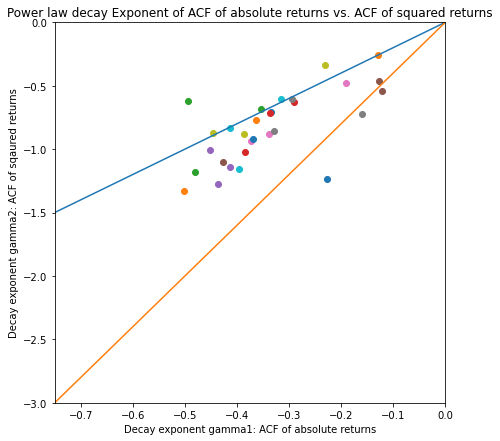

In [131]:
plt.figure(figsize=(7,7))
for index in range(len(acf_abs_returns_per_stock)):
    exponent_acf_abs_returns = return_powerlaw_exponent_of_ACF_series(acf_abs_returns_per_stock[index])
    exponent_acf_squared_returns = return_powerlaw_exponent_of_ACF_series(acf_squared_returns_per_stock[index])
    plt.scatter(exponent_acf_abs_returns,exponent_acf_squared_returns, label = returns.columns[index])
    # scaling relationhip 1: gamma1 = gamma2
    gamma1 = np.linspace(-1, 0, 100)
    # scaling relationhip 2: gamma1 = 2*gamma2
    gamma2 = gamma1*2
plt.xlim(-0.75, 0)
plt.ylim(-3, 0)
plt.plot(gamma1, gamma2, label = 'Scaling relationship 1: gamma1 = gamma2')
plt.plot(gamma1, 2*gamma2, label = 'Scaling relationship 1: gamma1 = 2*gamma2')
plt.xlabel('Decay exponent gamma1: ACF of absolute returns')
plt.ylabel('Decay exponent gamma2: ACF of sqaured returns')
plt.title('Power law decay Exponent of ACF of absolute returns vs. ACF of squared returns')
plt.show()

# Comparing S&P 500 total index closing ACF 

### Next, we move on to reproducing figure 4 of Feng et al.'s paper.

Since the complete 40 year data of S&P index closing prices was not found during the timeframe (only for all stocks, but not for the index we take the last 10 years. The goal is to find out if the long term memory (ACF decay) is similair in both the empirical and simulated model data.

In [132]:
# we also code a normalization function to normalize the runs:

def normalise(returns):
    """
    Normalises an array
    """
    array = np.array(returns)
    return np.abs((array - array.mean())/array.std())

In [133]:
# The source of this data is the nasdaq website: https://www.nasdaq.com/market-activity/index/spx/historical

total_SnP500_index_closing =pd.read_csv('data/df_total_SnP500_closing_10_years_clean.csv', parse_dates = True, index_col = 'Date')



In [134]:
total_SnP500_index_closing

,Close/Last
Date,
2023-01-27,4070.56
2023-01-26,4060.43
2023-01-25,4016.22
2023-01-24,4016.95
2023-01-23,4019.81
...,...
2013-02-05,1511.29
2013-02-04,1495.71
2013-02-01,1513.17


In [135]:
# make a log return series
returns = total_SnP500_index_closing.apply(normalise).apply(np.log).diff().dropna()

In [136]:
# absolute returns
abs_returns = returns.abs().values.flatten()
# squared returns
squared_returns = returns.apply(np.square).values.flatten()


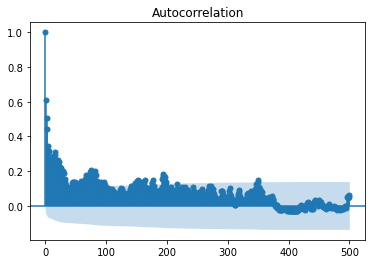

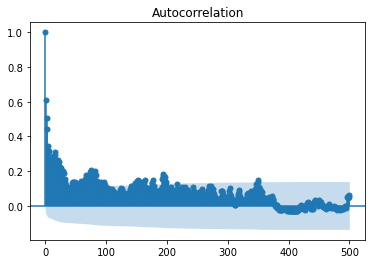

In [137]:
plot_acf(abs_returns, lags = 500)

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



The R-squared value = 0.1716696596718511
The powerlaw exponent of the decay of the ACF of is around: -0.5284483944299946


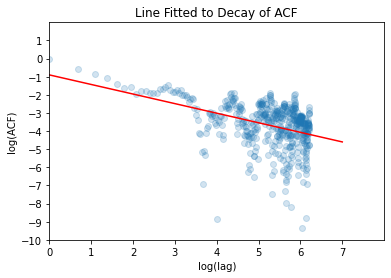

In [138]:
plot_log_acf_vs_fitted_line_to_decay_exponent(acf(normalise(abs_returns), nlags = 500))

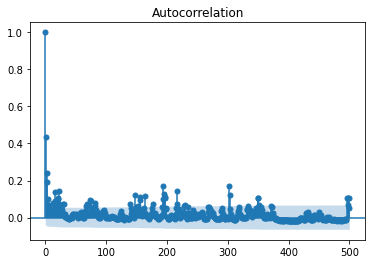

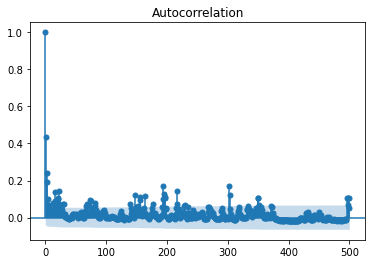

In [139]:
plot_acf(squared_returns, lags = 500)

In [140]:
plot_log_acf_vs_fitted_line_to_decay_exponent

<function __main__.plot_log_acf_vs_fitted_line_to_decay_exponent(y)>

The R-squared value = 0.42448321496465724
The powerlaw exponent of the decay of the ACF of is around: -0.9087302393348085


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



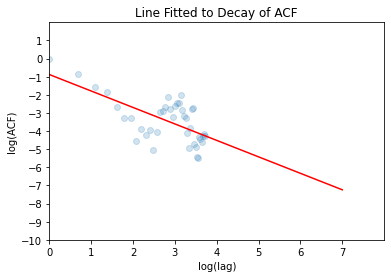

In [141]:
plot_log_acf_vs_fitted_line_to_decay_exponent(acf(normalise(squared_returns)))

We can see the empirical S&P 500 10 year ACF figures look different from Fengs paper, but we can see noteworthy autocorrelation existing in the left of the plots, just like fengs paper.

Now we compare against this autocorrelation to the ACF of the simulated data from the stochastic model with and without horizons

### Comparing ACF of abs returns with stochastic model without time horizons (1 run)

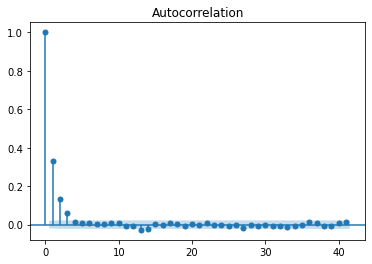

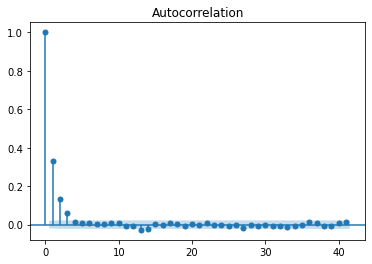

In [142]:
plot_acf(np.abs(normalise(stochastic_model_without_time_horizon_results[1][0])))

We can see that, for this run, the ACF of the absolute returns of the stochastic model without horozons for this model shows a similair autocorrelation on the left side plot as the SnP index

Showing the decay exponent of this ACF plot, with empirical V_f setting 0.4. This corresponds to the proportion of fundamental traders V_f, which we (as a simplifying assumption) assume to not have changes since the period of the paper.

The R-squared value = 0.47279502492776926
The powerlaw exponent of the decay of the ACF of is around: -1.1283171827406293


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



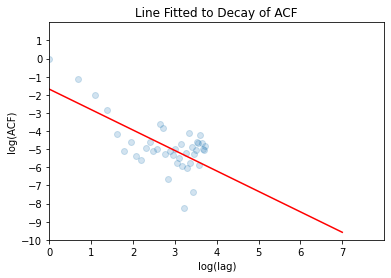

In [143]:
# we get the exponent of the absolute returns
plot_log_acf_vs_fitted_line_to_decay_exponent(acf(np.abs(normalise(stochastic_model_without_time_horizon_results[1][0]))))

### Comparing ACF of squared returns with stochastic model without time horizons (1 run)

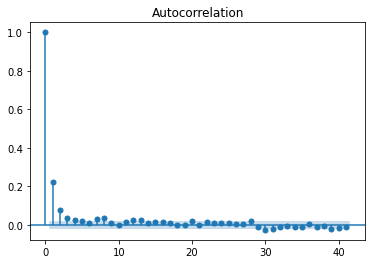

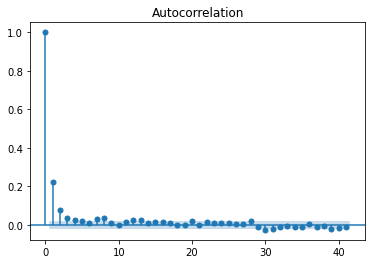

In [144]:
plot_acf(np.square(stochastic_model_with_time_horizon_results[1][0]))

We can see that, for this run, the ACF of the squared returns of the stochastic model with horozons for this model shows a similair autocorrelation on the left side plot as the SnP index

The R-squared value = 0.3204937595809325
The powerlaw exponent of the decay of the ACF of is around: -1.1409896546517957


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



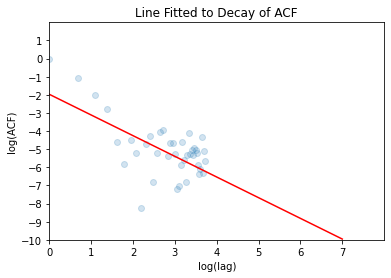

In [145]:
# we get the exponent of the squared returns
plot_log_acf_vs_fitted_line_to_decay_exponent(acf(np.square(normalise(stochastic_model_without_time_horizon_results[1][0]))))

### Comparing ACF of abs returns with stochastic model with time horizons (1 run)

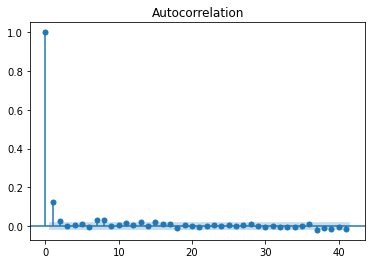

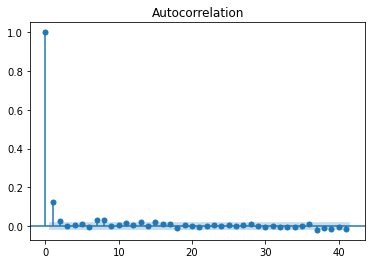

In [146]:
plot_acf(np.abs(normalise(stochastic_model_with_time_horizon_results[1][0])))

We can see that, for this run, the ACF of the absolute returns of the stochastic model without horozons for this model shows a similair autocorrelation on the left side plot as the SnP index

Showing the decay exponent of this ACF plot, with empirical V_f setting 0.4. This corresponds to the proportion of fundamental traders V_f, which we (as a simplifying assumption) assume to not have changes since the period of the paper.

The R-squared value = 0.28187030277856184
The powerlaw exponent of the decay of the ACF of is around: -0.9216371109526854


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



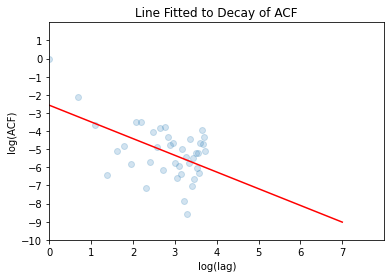

In [147]:
# we get the exponent of the absolute returns
plot_log_acf_vs_fitted_line_to_decay_exponent(acf(normalise(np.abs(stochastic_model_with_time_horizon_results[1][0]))))

### Simulated power law ACF exponents aggregation across mutiple runs & comparison vs. empirical

In this section we aggregate the power law exponent fitting across mutiple runs, for both the stochastic model with and without horizons. After we make a conclusion comparing results to Feng et al's 2012 paper. We will not plot ACF's for all runs, in order to reduce bloat and we will just focus on the exponents of the ACF decay functions here.

Comparing the fit on abs returns (no time horizon, i.e. no memory)

In [148]:
print('Stochastic model without time horizon, absolute returns, V_f = 0.4')
average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_without_horizons = []
for run in range(10):
    abs_exponent = return_powerlaw_exponent_of_ACF_series(acf(np.abs(normalise(stochastic_model_without_time_horizon_results[1][run])),500))
    print('exponent run '+ str(run+1) + ': ' + str(abs_exponent))
    average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_without_horizons.append(abs_exponent)
print('average exponent', np.mean(average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_without_horizons))
print('min exponent', np.min(average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_without_horizons))
print('max exponent', np.max(average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_without_horizons))
SnP500_abs_returns_exponent = (return_powerlaw_exponent_of_ACF_series(acf(abs_returns,nlags = 500)))
print('S&P500 exponent: ', SnP500_abs_returns_exponent)
difference_no_time_horizon_abs_returns = np.mean(average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_without_horizons) - SnP500_abs_returns_exponent
print('difference between average exponent and S&P500 exponent:', difference_no_time_horizon_abs_returns)



C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\st

Stochastic model without time horizon, absolute returns, V_f = 0.4
exponent run 1: -1.1270651569229204
exponent run 2: -0.9895960718843915
exponent run 3: -0.996696413718682
exponent run 4: -0.964624454191421
exponent run 5: -1.158200392486498
exponent run 6: -1.0517611426855742
exponent run 7: -0.9550058688177261
exponent run 8: -1.187566274419323
exponent run 9: -0.9698313856469354
exponent run 10: -0.9173200959344766
average exponent -1.031766725670795
min exponent -1.187566274419323
max exponent -0.9173200959344766
S&P500 exponent:  -0.8201263813788141
difference between average exponent and S&P500 exponent: -0.21164034429198086


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\st

Comparing the fit on squared returns (no time horizon, i.e. no memory)

In [149]:
print('Stochastic model without time horizon, squared returns, V_f = 0.4')
average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_without_horizons = []
for run in range(10):
    squared_exponent = return_powerlaw_exponent_of_ACF_series(acf(np.square(normalise(stochastic_model_without_time_horizon_results[1][run])),500))
    print('exponent run '+ str(run+1) + ': ' + str(squared_exponent))
    average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_without_horizons.append(squared_exponent)
print('average exponent', np.mean(average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_without_horizons))
print('min exponent', np.min(average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_without_horizons))
print('max exponent', np.max(average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_without_horizons))
SnP500_square_returns_exponent = (return_powerlaw_exponent_of_ACF_series(acf(squared_returns, nlags = 500)))
print('S&P500 exponent: ', SnP500_square_returns_exponent)
difference_no_time_horizon_squared_returns = np.mean(average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_without_horizons) - SnP500_square_returns_exponent
print('difference between average exponent and S&P500 exponent: ', difference_no_time_horizon_squared_returns)



Stochastic model without time horizon, squared returns, V_f = 0.4
exponent run 1: -1.1397376288340864
exponent run 2: -1.056702008716037
exponent run 3: -1.0700415179230727


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\st

exponent run 4: -0.8456755673714476
exponent run 5: -1.1433921937628622
exponent run 6: -0.9520102231996916
exponent run 7: -1.1653934962186305
exponent run 8: -1.1326987495583576
exponent run 9: -0.9942284647316845
exponent run 10: -1.114968393828662
average exponent -1.061484824414453
min exponent -1.1653934962186305
max exponent -0.8456755673714476
S&P500 exponent:  -0.325242855875452
difference between average exponent and S&P500 exponent:  -0.736241968539001


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\st

Comparing the fit on abs returns (with time horizon, i.e. long term memory)

In [150]:
print('Stochastic model with time horizon, absolute returns, V_f = 0.4')
average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_with_horizons = []
for run in range(10):
    abs_exponent = return_powerlaw_exponent_of_ACF_series(acf(normalise(np.abs(stochastic_model_with_time_horizon_results[1][run])),500))
    print('exponent run '+ str(run+1) + ': ' + str(abs_exponent))
    average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_with_horizons.append(abs_exponent)
print('average exponent', np.mean(average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_with_horizons))
print('min exponent', np.min(average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_with_horizons))
print('max exponent', np.max(average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_with_horizons))
SnP500_abs_returns_exponent = (return_powerlaw_exponent_of_ACF_series(acf(abs_returns,nlags = 500)))
print('S&P500 exponent: ', SnP500_abs_returns_exponent)
difference_time_horizon_abs_returns = np.mean(average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_with_horizons) - SnP500_abs_returns_exponent
print('difference between average exponent and S&P500 exponent: ', difference_time_horizon_abs_returns)

Stochastic model with time horizon, absolute returns, V_f = 0.4
exponent run 1: -0.920385085134976
exponent run 2: -1.0016282727850154
exponent run 3: -0.8553639692607194


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\st

exponent run 4: -1.0010550307242192
exponent run 5: -0.8308399207186851
exponent run 6: -1.1246095034257215
exponent run 7: -1.0173325835159617
exponent run 8: -1.082771442006925
exponent run 9: -0.9510485590121068
exponent run 10: -0.8747324567873986
average exponent -0.9659766823371729
min exponent -1.1246095034257215
max exponent -0.8308399207186851
S&P500 exponent:  -0.8201263813788141
difference between average exponent and S&P500 exponent:  -0.14585030095835883


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\st

Comparing the fit on squared returns (with time horizon, i.e. long term memory)

In [151]:
print('Stochastic model with time horizon, squared returns, V_f = 0.4')
average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_with_horizons = []
for run in range(10):
    squared_exponent = return_powerlaw_exponent_of_ACF_series(acf(np.square(normalise(stochastic_model_with_time_horizon_results[1][run])),500))
    print('exponent run '+ str(run+1) + ': ' + str(squared_exponent))
    average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_with_horizons.append(squared_exponent)
print('average exponent', np.mean(average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_with_horizons))
print('min exponent', np.min(average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_with_horizons))
print('max exponent', np.max(average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_with_horizons))
SnP500_square_returns_exponent = (return_powerlaw_exponent_of_ACF_series(acf(squared_returns, nlags = 500)))
print('S&P500 exponent: ', SnP500_square_returns_exponent)
difference_time_horizon_squared_returns = np.mean(average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_with_horizons) - SnP500_square_returns_exponent
print('difference between average exponent and S&P500 exponent: ', difference_time_horizon_squared_returns)



Stochastic model with time horizon, squared returns, V_f = 0.4
exponent run 1: -0.8266929580837136
exponent run 2: -1.2073461236869474
exponent run 3: -0.994056249574377


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\st

exponent run 4: -1.0788092800667815
exponent run 5: -0.820411594943266
exponent run 6: -1.2417570598696086
exponent run 7: -1.0492005333923222
exponent run 8: -1.0721764400227864
exponent run 9: -1.1743724767155124
exponent run 10: -1.0778229179186174
average exponent -1.054264563427393
min exponent -1.2417570598696086
max exponent -0.820411594943266
S&P500 exponent:  -0.325242855875452
difference between average exponent and S&P500 exponent:  -0.7290217075519411


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.

C:\Anaconda\lib\site-packages\statsmodels\tsa\st

In [152]:
SnP500_square_returns_exponent

-0.325242855875452

In [153]:
SnP500_abs_returns_exponent

-0.8201263813788141

In [154]:
print('difference_no_time_horizon_abs_returns:', np.round(difference_no_time_horizon_abs_returns,2))
print('difference_time_horizon_abs_returns:', np.round(difference_time_horizon_abs_returns,2))
print('difference_no_time_horizon_squared_returns:', np.round(difference_no_time_horizon_squared_returns,2))
print('difference_time_horizon_squared_returns:', np.round(difference_time_horizon_squared_returns,2))
numerical_gamma1_with_horizons = np.mean(average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_with_horizons)
numerical_gamma2_with_horizons = np.mean(average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_with_horizons)
numerical_scaling_relationship_with_horizons = numerical_gamma2_with_horizons/numerical_gamma1_with_horizons
print('numerical_scaling_relationship_with_horizons:', np.round(numerical_scaling_relationship_with_horizons,2))
numerical_gamma1_without_horizons = np.mean(average_powerlaw_exponent_of_ACF_series_of_abs_returns_of_stochastic_without_horizons)
numerical_gamma2_without_horizons = np.mean(average_powerlaw_exponent_of_ACF_series_of_squared_returns_of_stochastic_without_horizons)
numerical_scaling_relationship_without_horizons = numerical_gamma2_without_horizons/numerical_gamma1_without_horizons
print('numerical_scaling_relationship_without_horizons:', np.round(numerical_scaling_relationship_without_horizons,2))
print('numerical_gamma1_with_horizons:', np.round(numerical_gamma1_with_horizons,2))
print('numerical_gamma2_with_horizons:', np.round(numerical_gamma2_with_horizons,2))
print('scaling relationship S&P:', np.round((SnP500_square_returns_exponent/SnP500_abs_returns_exponent),2))

difference_no_time_horizon_abs_returns: -0.21
difference_time_horizon_abs_returns: -0.15
difference_no_time_horizon_squared_returns: -0.74
difference_time_horizon_squared_returns: -0.73
numerical_scaling_relationship_with_horizons: 1.09
numerical_scaling_relationship_without_horizons: 1.03
numerical_gamma1_with_horizons: -0.97
numerical_gamma2_with_horizons: -1.05
scaling relationship S&P: 0.4


### Conclusion ACF decay exponent fitting

The difference between empirical values and the model is fairly large as we can see, compared to Fengs paper. 


Feng et al define the relationships as follows:

γ1: ACF decay exponent of absolute returns
γ2: ACF decay exponent of squared returns

Feng et al find the following parameters: 

γ1,simulation = 0.40
γ1,S&P500 = 0.44

Leading to γ1 difference of -0.04 where we find γ1 difference -0.80 for the no horizons case and -0.61 for the horizons case of our stochastic model

γ2,simulation = 0.53
γ2,S&P500 = 0.7

Leading to γ2 difference of -0.17 where we find γ1 difference -0.97 for the no horizons case and -0.80 for the horizons case of our stochastic model



We can thus see that our fit of the data is not that good, but adding the investor memory component does improve the fit of the model (although we don't test if this improvement is significant). Feng et al does not make a distinction between a model that adds time horizons and does not, and in fact only use the model that has time horizons. 

The result in our case is evidence, for the face that adding a time horizons component to the stochastic model (long term memory) could increase the quality of fit using these samples, although further researsh is required to establish this fact and test if the difference is significance.



# Parameter tuning & further (sensitivity) analysis

In [155]:
# other parameters
n = 2**10
t = 10000
p = 0.02178
omega = 1
b = 1
size = 1
k = 1
M = 500
d = 1.12

In [156]:
def r_squared(data, alpha, beta, x_range):
    """
    Goodness of fit test for regression
    """
    ss_res = []
    ss_total = []
    mean = np.mean(data)

    for i in range(len(x_range)):
        prediction = alpha + beta * x_range[i]
        value = data[i]

        residual = (value - prediction) ** 2
        total = (value - mean) ** 2

        ss_res.append(residual)
        ss_total.append(total)

    return 1 - (sum(ss_res) / sum(ss_total))

In [157]:
def dict_to_df(dict, range) -> pd.DataFrame:
    df = pd.DataFrame(dict)
    df_transp = df.transpose()
    df_transp.columns = range
    df_transp.drop("Range")
    
    return df_transp

In [158]:
iterations = 1

In [159]:
# variances for return and volume for different n values
n_range = [2**i for i in range(9, 15)]
dict_return_variances_n = {'Range': n_range}
dict_volume_variances_n = {'Range': n_range}

for run in range(iterations):
    return_variances = []
    volume_variances = []

    for i in n_range:
        n = i
        n_test = Model(p, n, size, k, omega, b=1)
        for step in range(t):
            n_test.step()
        
        return_variance = np.var(n_test.daily_returns)
        volume_variance = np.var(n_test.daily_trading_volumes)
        
        return_variances.append(return_variance)
        volume_variances.append(volume_variance)
    
    dict_return_variances_n[f'Iteration {run}'] = return_variances
    dict_volume_variances_n[f'Iteration {run}'] = volume_variances

    print(run)

0


In [160]:
# to pandas
df_return_variances_n = dict_to_df(dict_return_variances_n, n_range)
df_volume_variances_n = dict_to_df(dict_volume_variances_n, n_range)

# save to csv
df_return_variances_n.to_csv('return_variances_n.csv')
df_volume_variances_n.to_csv('volume_variances_n.csv')
     

In [161]:

# mean and sd
mean_return_variances_n = df_return_variances_n.mean()
sd_return_variances_n = df_return_variances_n.std()

mean_volume_variances_n = df_volume_variances_n.mean()
sd_volume_variances_n = df_volume_variances_n.std()

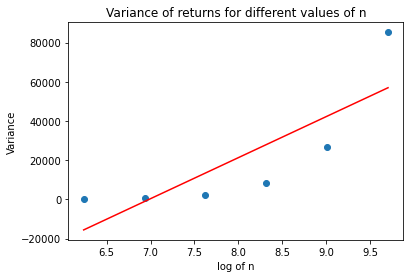

R^2: 0.6707018243245286)
intercept: -146123.8485176349
coefficient: [20927.35165466]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.046194473017282967
Thus, we reject the null hypothesis in favor of the alternative hypothesis
However, the sample size is 6 so the results are not very reliable


In [162]:

# plot return regression for n
plot_regression(np.log(n_range), mean_return_variances_n, "Variance of returns for different values of n", 'log of n', 'Variance', variance=True)
     

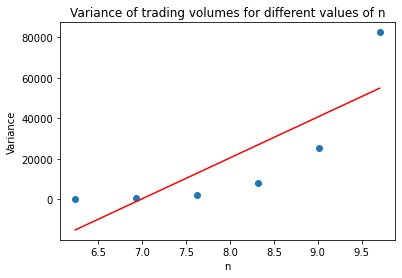

R^2: 0.6660972711462352)
intercept: -140841.90123018099
coefficient: [20162.71520998]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.04759518283291042
Thus, we reject the null hypothesis in favor of the alternative hypothesis
However, the sample size is 6 so the results are not very reliable


In [163]:
# plot volume regression for n
plot_regression(np.log(n_range), mean_volume_variances_n, "Variance of trading volumes for different values of n", 'n', 'Variance', variance=True)

In [164]:

# variances for return and volume for different k values
k_range = [i*0.5 for i in range(1, 51, 5)]

dict_return_variances_k = {'Range': k_range}
dict_volume_variances_k = {'Range': k_range}

for run in range(iterations):
    return_variances = []
    volume_variances = []


    for i in k_range:
        k = i
        k_test = Model(p, n, size, k, omega, b=1)
        for step in range(t):
            k_test.step()

        return_variance = np.var(k_test.daily_returns)
        volume_variance = np.var(k_test.daily_trading_volumes)
        volume_variances.append(volume_variance)
        return_variances.append(return_variance)

    dict_return_variances_k[f"Iteration {run}"] = return_variances
    dict_volume_variances_k[f"Iteration {run}"] = volume_variances

    print(run)

0


In [165]:

df_return_variances_k = dict_to_df(dict_return_variances_k, k_range)
df_volume_variances_k = dict_to_df(dict_volume_variances_k, k_range)

df_return_variances_k.to_csv('data/return_variances_k.csv')
df_volume_variances_k.to_csv('data/volume_variances_k.csv')
     

In [166]:
k_return_variances_mean = np.array(df_return_variances_k.mean())
k_volume_variances_mean = np.array(df_volume_variances_k.mean())
k_return_variances_sd = np.array(df_return_variances_k.std())
k_volume_variances_sd = np.array(df_volume_variances_k.std())

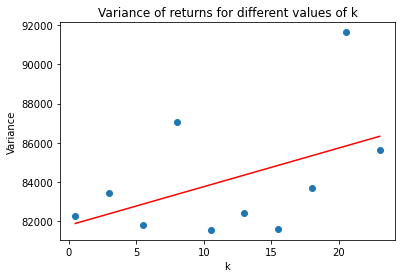

R^2: 0.2169419984572848)
intercept: 81793.312340478
coefficient: [197.30167395]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.1748785516871243
Thus, we fail to reject the null hypothesis


In [167]:
# plot return regression for k
plot_regression(k_range, k_return_variances_mean, "Variance of returns for different values of k", 'k', 'Variance', variance=True)
     

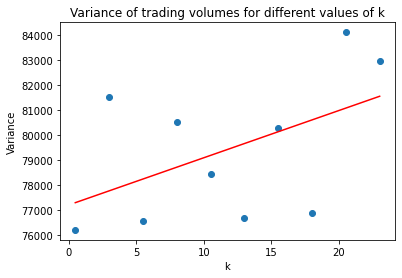

R^2: 0.24859970892523953)
intercept: 77213.52427728036
coefficient: [189.2564957]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.14241098706037514
Thus, we fail to reject the null hypothesis


In [168]:
# plot volume regression for k
plot_regression(k_range, k_volume_variances_mean, "Variance of trading volumes for different values of k", 'k', 'Variance', variance=True)

In [169]:
# omega values for return and volume for different k values
omega_range = [i*0.1 for i in range(1, 10)]
omega_return_dict = {'Range': omega_range}
omega_volume_dict = {'Range': omega_range}

for run in range(iterations):
    return_variances = []
    volume_variances = []

    for i in omega_range:
        omega = i
        omega_test = Model(p, n, size, k, i, b=1)
        for step in range(t):
            omega_test.step()

        return_variance = np.var(omega_test.daily_returns)
        volume_variance = np.var(omega_test.daily_trading_volumes)
        volume_variances.append(volume_variance)
        return_variances.append(return_variance)

    omega_return_dict[f"Iteration {run}"] = return_variances
    omega_volume_dict[f"Iteration {run}"] = volume_variances

    print(run)

0


In [170]:
df_omega_return_variances = dict_to_df(omega_return_dict, omega_range)
df_omega_volume_variances = dict_to_df(omega_volume_dict, omega_range)
df_omega_return_variances.to_csv('data/return_variances_omega.csv')
df_omega_volume_variances.to_csv('data/volume_variances_omega.csv')

In [171]:
omega_return_means = np.array(df_omega_return_variances.mean())
omega_volume_means = np.array(df_omega_volume_variances.mean())

omega_return_sd = np.array(df_omega_return_variances.std())
omega_volume_sd = np.array(df_omega_volume_variances.std())

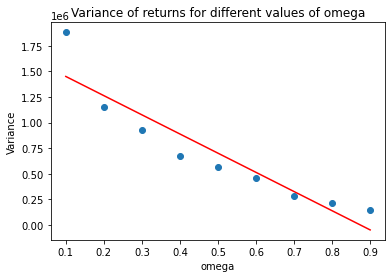

R^2: 0.8631951973220116)
intercept: 1639096.135923489
coefficient: [-1875294.81612806]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.0002916309576703746
Thus, we reject the null hypothesis in favor of the alternative hypothesis
However, the sample size is 9 so the results are not very reliable


In [172]:
# Return variance for different values of omega
plot_regression(omega_range, omega_return_means, "Variance of returns for different values of omega", 'omega', 'Variance', variance=True)

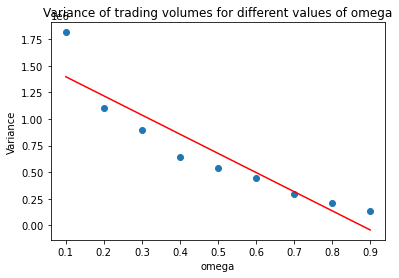

R^2: 0.8623062094399575)
intercept: 1577882.7793698043
coefficient: [-1799964.42617163]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.0002984344479326495
Thus, we reject the null hypothesis in favor of the alternative hypothesis
However, the sample size is 9 so the results are not very reliable


In [173]:
# Volume variance for different values of omega
plot_regression(omega_range, omega_volume_means, "Variance of trading volumes for different values of omega", 'omega', 'Variance', variance=True)

In [174]:
# p_test - return and volume variances
p_range = [i*0.1 for i in range(1, 6)]

dict_return_variances_p = {'Range': p_range}
dict_volume_variances_p = {'Range': p_range}

for run in range(iterations):
    returns = []
    volumes = []

    for i in p_range:
        p = i
        p_test = Model(p, n, size, k, omega, b=1)
        
        for step in range(t):
            p_test.step()

        return_variance = np.var(p_test.daily_returns)
        volume_variance = np.var(p_test.daily_trading_volumes)
        returns.append(return_variance)
        volumes.append(volume_variance)

    dict_return_variances_p[f"Iteration {run}"] = returns
    dict_volume_variances_p[f"Iteration {run}"] = volumes

print(run)


0


In [175]:
df_return_variances_p = dict_to_df(dict_return_variances_p, p_range)
df_volume_variances_p = dict_to_df(dict_volume_variances_p, p_range)

df_return_variances_p.to_csv('data/return_variances_p.csv')
df_volume_variances_p.to_csv('data/volume_variances_p.csv')

In [176]:
p_return_means = np.array(df_return_variances_p.mean())
p_return_sd = np.array(df_return_variances_p.std())

p_volume_means = np.array(df_volume_variances_p.mean())
p_volume_sd = np.array(df_volume_variances_p.std())


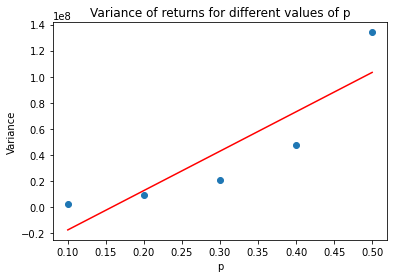

R^2: 0.7861552487795088)
intercept: -47564981.37953719
coefficient: [3.01756657e+08]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.045021327560735624
Thus, we reject the null hypothesis in favor of the alternative hypothesis
However, the sample size is 5 so the results are not very reliable


In [177]:
# Return variance for different values of p
plot_regression(p_range, p_return_means, "Variance of returns for different values of p", 'p', 'Variance', variance=True)

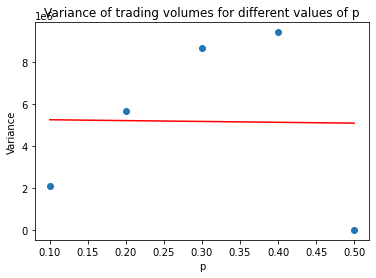

R^2: 0.00024616951827294287)
intercept: 5291758.22331236
coefficient: [-405853.14411915]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.9800239582436243
Thus, we fail to reject the null hypothesis


In [178]:
# Volume variance for different values of p
plot_regression(p_range, p_volume_means, "Variance of trading volumes for different values of p", 'p', 'Variance', variance=True)

In [179]:
# b_test - return and volume variances
b_range = [i*0.5 for i in range(0, 6)]

dict_return_variances_b = {'Range': b_range}
dict_volume_variances_b = {'Range': b_range}

for run in range(iterations):
    returns = []
    volumes = []

    for i in b_range:
        b = i
        b_test = Model(p, n, size, k, omega, b=1)
        
        for step in range(t):
            b_test.step()

        return_variance = np.var(b_test.daily_returns)
        volume_variance = np.var(b_test.daily_trading_volumes)
        returns.append(return_variance)
        volumes.append(volume_variance)

    dict_return_variances_b[f"Iteration {run}"] = returns
    dict_volume_variances_b[f"Iteration {run}"] = volumes

print(run)


0


In [180]:
# Convert to dataframes
df_return_variances_b = dict_to_df(dict_return_variances_b, b_range)
df_volume_variances_b = dict_to_df(dict_volume_variances_b, b_range)

# Save to csv
df_return_variances_b.to_csv('data/return_variances_b.csv')
df_volume_variances_b.to_csv('data/volume_variances_b.csv')

In [181]:
# Means and standard deviations
b_return_means = np.array(df_return_variances_b.mean())
b_return_sd = np.array(df_return_variances_b.std())

b_volume_means = np.array(df_volume_variances_b.mean())
b_volume_sd = np.array(df_volume_variances_b.std())

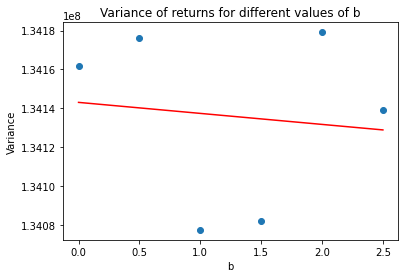

R^2: 0.01336707539257942)
intercept: 134143058.13126117
coefficient: [-5662.44620358]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.8273486209735226
Thus, we fail to reject the null hypothesis


In [182]:
# Return variance for different values of b
plot_regression(b_range, b_return_means, "Variance of returns for different values of b", 'b', 'Variance', variance=True)

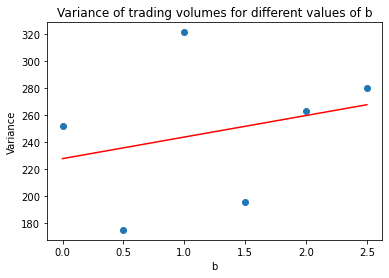

R^2: 0.07584635418043195)
intercept: 227.84922715928596
coefficient: [15.8956619]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.5973408730783811
Thus, we fail to reject the null hypothesis


In [183]:
# Volume variance for different values of b
plot_regression(b_range, b_volume_means, "Variance of trading volumes for different values of b", 'b', 'Variance', variance=True)

In [184]:
# m_test - return and volume variances
m_range = [i for i in range(1, 10)]
m_dict = {'Range': m_range}

for run in range(iterations):
    returns = []
    volumes = []

    for i in m_range:
        m = i
        m_test = Stochastic_Model(n, p, init=10, time_horizon=True, M=i, d=d)
        
        for step in range(t):
            m_test.step()

        return_variance = np.var(m_test.returns)
        returns.append(return_variance)

    m_dict[f"Iteration {run}"] = returns


In [185]:
df_return_variances_m = dict_to_df(m_dict, m_range)
df_return_variances_m.to_csv('data/return_variances_m.csv')


In [186]:
m_return_means = np.array(df_return_variances_m.mean())
m_return_sd = np.array(df_return_variances_m.std())

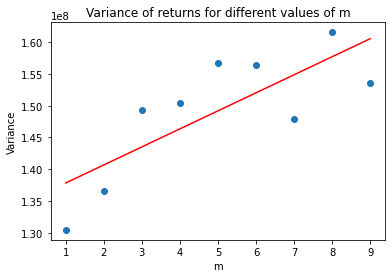

R^2: 0.6090603351909744)
intercept: 135005886.08174643
coefficient: [2837013.30940641]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.01307820979113461
Thus, we reject the null hypothesis in favor of the alternative hypothesis
However, the sample size is 9 so the results are not very reliable


In [187]:
# Return variance for different values of m
plot_regression(m_range, m_return_means, "Variance of returns for different values of m", 'm', 'Variance', variance=True)

In [188]:
# d_test - return and volume variances
d_range = [i*0.1 for i in range(1, 10)]
d_dict = {'Range': d_range}

for run in range(iterations):
    return_variances = []

    for i in d_range:
        d = i
        d_test = Stochastic_Model(n, p, init=10, time_horizon=True, M=M, d=d)
        
        for step in range(t):
            d_test.step()

        return_variance = np.var(d_test.returns)
        return_variances.append(return_variance)

    d_dict[f"Iteration {run}"] = return_variances
    
    print(run)

0


In [189]:
df_return_variances_d = dict_to_df(d_dict, d_range)
df_return_variances_d.to_csv('data/return_variances_d.csv')

In [190]:
# Mean and sd for return variances
d_return_means = np.array(df_return_variances_d.mean())
d_return_sd = np.array(df_return_variances_d.std())

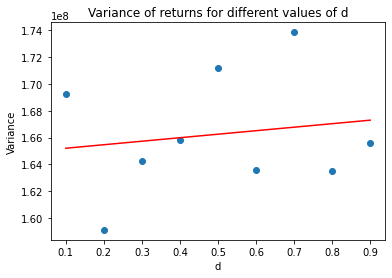

R^2: 0.025478631311406486)
intercept: 164938858.7534476
coefficient: [2613154.54589854]
Null hypothesis: the coefficient is zero
Alternative hypothesis: the coefficient is not zero
If p value is less than 0.05, we reject the null hypothesis
p value: 0.6816495272142076
Thus, we fail to reject the null hypothesis


In [191]:
# Return variance for different values of d
plot_regression(d_range, d_return_means, "Variance of returns for different values of d", 'd', 'Variance', variance=True)